## Import Necessary library

In [1]:
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel,BertConfig
from torch.amp import autocast, GradScaler
import numpy as np
import os
import warnings

# Suppress warnings for a cleaner output.
warnings.filterwarnings("ignore")

## Setting Seeds for Reproducibility
This code block is important to ensure the results of the experiment are reproducible. By having a fixed "seed" for all sources of randomness (such as Python's random, NumPy and PyTorch), we can ensure that anyone running this code will obtain exactly the same output, which is important for debugging and comparing results.

The function set_seeds accepts an integer as input and uses it to initialise the random number generators for all the relevant libraries. After defining the function we also clear the GPU cache to free up memory and then call the function with a specific seed (2025) to apply it globally.

In [2]:
def set_seeds(seed):
    """
    Sets the seed for all major sources of randomness to ensure reproducibility.
    """
    # Set seed for PyTorch global seed
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    # Set seed for Python's built-in random module
    random.seed(seed)
    # Set seed for NumPy
    np.random.seed(seed)
    # Set seed for PyTorch's CPU random number generator
    torch.manual_seed(seed)
    # Set seed for PyTorch's current GPU random number generator
    torch.cuda.manual_seed(seed)
    # Set seed for all available GPUs (if using multi-GPU)
    torch.cuda.manual_seed_all(seed)

# Clear the unused memory from the GPU cache
torch.cuda.empty_cache()

# I use the year 2025 as my chosen seed value. 
# Any integer would work, but it's good practice to pick a specific one and stick to it.
set_seeds(2025)

## Dataset and Template Definitions
This section defines the core components for generating a multilingual dataset for training and validation. The dataset is constructed from two main parts:
- Object Lists: A vocabulary of common objects in several languages.
- Sentence Templates: A set of sentences containing a placeholder {object} that are intended to be used in combination with the object lists.

These templates are divided by language and intent, and they span a broad spectrum of styles - from formal and conversational to colloquial and even grammatically incorrect phrases. This variety is essential for creating a robust Natural Language Understanding (NLU) model that can manage real-world user input.
The data is divided into train and Validation data. The model is trained on the train data and the model's performance is tested on the unseen Validation data.

## Structure of Templates
Each template dictionary uses integer keys as labels:
- Key 0: Used for queries about the existence or properties of an object as well as general conversation. These are usually non-actionable questions (e.g. "Is the apple on the table?").
- Key 1: Is used to represent action-oriented commands. These are instructions to an agent to do something (e.g., "Please pick up the apple.").

In [3]:
objects_en = [
    "airpod", "apple", "apron", "backpack", "bag", "ball", "balloon", "banana", "battery", "bed",
    "belt", "bell", "binder", "blanket", "blender", "book", "bookshelf", "bottle", "bottle opener", "bowl",
    "box", "bracelet", "bread", "brick", "broom", "brush", "bucket", "button", "cabinet", "cable",
    "calculator", "camera", "can", "candle", "canvas", "cap", "card", "carpet", "cd", "chair",
    "chain", "charger", "cheese", "cigarette", "clip", "clock", "closet", "cloth", "coaster", "coat",
    "coin", "comb", "computer", "conditioner", "container", "corkscrew", "couch", "cushion", "cup", "curtain",
    "cutting board", "dice", "dishwasher", "doll", "door", "doorknob", "drawer", "dress", "drill", "drone",
    "drum", "dvd", "earbuds", "egg", "envelope", "eraser", "fan", "file", "flag", "flashlight",
    "flower", "folder", "fork", "fridge", "game controller", "glasses", "glove", "glue", "gluestick", "guitar",
    "hammer", "hanger", "hard drive", "hat", "headphones", "heater", "helmet", "highlighter", "hanger", "iron",
    "jacket", "jar", "jeans", "jug", "kettle", "key", "keyboard", "knife", "ladle", "ladder",
    "lamp", "laptop", "lemon", "letter", "lighter", "light switch", "lock", "lotion", "loudspeaker", "magnet",
    "map", "marker", "mask", "matchbox", "microwave", "mirror", "modem", "monitor", "mop", "mouse",
    "mug", "nail", "napkin", "necklace", "needle", "notebook", "nut", "onion", "orange", "oven",
    "oven mitt", "package", "paintbrush", "painting", "pan", "pants", "paper", "paper clip", "pen", "pencil",
    "pepper shaker", "perfume", "phone", "photo", "picture frame", "pillow", "placemat", "plant", "plate", "pliers",
    "plug", "pocket", "pot", "potato", "power outlet", "printer", "puzzle", "radio", "razor", "remote",
    "remote control", "ring", "rope", "ruler", "rug", "salt shaker", "sandwich", "saucer", "saw", "scarf",
    "scissors", "screw", "screwdriver", "shampoo", "sheet", "shirt", "shoe", "shopping bag", "shorts", "soap",
    "sock", "soda can", "sofa", "spatula", "speaker", "sponge", "spoon", "stapler", "sticker", "sticky note",
    "stool", "stove", "string", "sunglasses", "table", "tablet", "tape", "tape measure", "teapot", "television",
    "tennis ball", "tent", "thermos", "thread", "ticket", "tie", "tissue", "toaster", "toilet paper", "tomato",
    "tongs", "toothbrush", "toothpaste", "towel", "toy", "trash can", "tray", "t-shirt", "tv control", "tweezers",
    "umbrella", "usb drive", "vacuum cleaner", "vase", "wallet", "wardrobe", "watch", "webcam", "whistle", "window",
    "wine glass", "wrench", "zipper"
]
objects_fa = [
    "ایرپاد", "سیب", "پیش‌بند", "کوله‌پشتی", "کیف", "توپ", "بادکنک", "موز", "باتری", "تختخواب",
    "کمربند", "زنگوله", "کلاسور", "پتو", "مخلوط‌کن", "کتاب", "قفسه کتاب", "بطری", "دربازکن بطری", "کاسه",
    "جعبه", "دستبند", "نان", "آجر", "جارو", "برس", "سطل", "دکمه", "کابینت", "کابل",
    "ماشین حساب", "دوربین", "قوطی", "شمع", "بوم نقاشی", "کلاه نقاب‌دار", "کارت", "فرش", "سی‌دی", "صندلی",
    "زنجیر", "شارژر", "پنیر", "سیگار", "گیره", "ساعت", "کمد", "پارچه", "زیرلیوانی", "کت",
    "سکه", "شانه", "کامپیوتر", "نرم‌کننده مو", "ظرف", "چوب‌پنبه‌کش", "کاناپه", "کوسن", "فنجان", "پرده",
    "تخته گوشت", "تاس", "ماشین ظرفشویی", "عروسک", "در", "دستگیره در", "کشو", "لباس زنانه", "دریل", "پهپاد",
    "طبل", "دی‌وی‌دی", "ایرباد", "تخم‌مرغ", "پاکت‌نامه", "پاک‌کن", "پنکه", "پرونده", "پرچم", "چراغ قوه",
    "گل", "پوشه", "چنگال", "یخچال", "دسته بازی", "عینک", "دستکش", "چسب", "چسب ماتیکی", "گیتار",
    "چکش", "چوب‌لباسی", "هارد دیسک", "کلاه", "هدفون", "بخاری", "کلاه ایمنی", "ماژیک هایلایت", "چوب لباسی", "اتو",
    "ژاکت", "شیشه مربا", "شلوار جین", "پارچ", "کتری", "کلید", "کیبورد", "چاقو", "ملاقه", "نردبان",
    "چراغ", "لپ‌تاپ", "لیمو", "نامه", "فندک", "کلید برق", "قفل", "لوسیون", "بلندگو", "آهن‌ربا",
    "نقشه", "ماژیک", "ماسک", "قوطی کبریت", "مایکروویو", "آینه", "مودم", "مانیتور", "تی", "ماوس",
    "لیوان بزرگ", "میخ", "دستمال سفره", "گردنبند", "سوزن", "دفترچه", "مهره", "پیاز", "پرتقال", "فر",
    "دستکش فر", "بسته", "قلم‌مو", "نقاشی", "ماهیتابه", "شلوار", "کاغذ", "گیره کاغذ", "خودکار", "مداد",
    "فلفل‌پاش", "عطر", "تلفن", "عکس", "قاب عکس", "بالش", "زیربشقابی", "گیاه", "بشقاب", "انبردست",
    "دوشاخه", "جیب", "قابلمه", "سیب‌زمینی", "پریز برق", "پرینتر", "پازل", "رادیو", "تیغ", "کنترل",
    "کنترل تلویزیون", "انگشتر", "طناب", "خط‌کش", "قالیچه", "نمک‌پاش", "ساندویچ", "نعلبکی", "اره", "شال",
    "قیچی", "پیچ", "پیچ‌گوشتی", "شامپو", "ملحفه", "پیراهن", "کفش", "کیسه خرید", "شلوارک", "صابون",
    "جوراب", "قوطی نوشابه", "مبل", "کفگیر", "اسپیکر", "اسفنج", "قاشق", "منگنه", "برچسب", "کاغذ یادداشت چسبی",
    "چهارپایه", "اجاق گاز", "نخ", "عینک آفتابی", "میز", "تبلت", "نوار چسب", "متر", "قوری", "تلویزیون",
    "توپ تنیس", "چادر", "فلاسک", "نخ", "بلیط", "کراوات", "دستمال کاغذی", "توستر", "دستمال توالت", "گوجه فرنگی",
    "انبر", "مسواک", "خمیردندان", "حوله", "اسباب‌بازی", "سطل زباله", "سینی", "تی‌شرت", "کنترل تلویزیون", "موچین",
    "چتر", "فلش مموری", "جاروبرقی", "گلدان", "کیف پول", "کمد لباس", "ساعت مچی", "وب‌کم", "سوت", "پنجره",
    "گیلاس شراب", "آچار", "زیپ"
]
objects_de = [
    "der AirPod", "der Apfel", "die Schürze", "der Rucksack", "die Tasche", "der Ball", "der Luftballon", "die Banane", "die Batterie", "das Bett",
    "der Gürtel", "die Glocke", "der Ordner", "die Decke", "der Mixer", "das Buch", "das Bücherregal", "die Flasche", "der Flaschenöffner", "die Schüssel",
    "die Kiste", "das Armband", "das Brot", "der Ziegelstein", "der Besen", "die Bürste", "der Eimer", "der Knopf", "der Schrank", "das Kabel",
    "der Taschenrechner", "die Kamera", "die Dose", "die Kerze", "die Leinwand", "die Kappe", "die Karte", "der Teppich", "die CD", "der Stuhl",
    "die Kette", "das Ladegerät", "der Käse", "die Zigarette", "die Klammer", "die Uhr", "der Schrank", "das Tuch", "der Untersetzer", "der Mantel",
    "die Münze", "der Kamm", "der Computer", "die Haarspülung", "der Behälter", "der Korkenzieher", "die Couch", "das Kissen", "die Tasse", "der Vorhang",
    "das Schneidebrett", "der Würfel", "die Spülmaschine", "die Puppe", "die Tür", "der Türknauf", "die Schublade", "das Kleid", "der Bohrer", "die Drohne",
    "die Trommel", "die DVD", "der Ohrhörer", "das Ei", "der Umschlag", "der Radiergummi", "der Ventilator", "die Akte", "die Flagge", "die Taschenlampe",
    "die Blume", "der Ordner", "die Gabel", "der Kühlschrank", "der Game-Controller", "die Brille", "der Handschuh", "der Klebstoff", "der Klebestift", "die Gitarre",
    "der Hammer", "der Kleiderbügel", "die Festplatte", "der Hut", "der Kopfhörer", "die Heizung", "der Helm", "der Textmarker", "der Kleiderbügel", "das Bügeleisen",
    "die Jacke", "das Marmeladenglas", "die Jeans", "der Krug", "der Wasserkocher", "der Schlüssel", "die Tastatur", "das Messer", "die Schöpfkelle", "die Leiter",
    "die Lampe", "der Laptop", "die Zitrone", "der Brief", "das Feuerzeug", "der Lichtschalter", "das Schloss", "die Lotion", "der Lautsprecher", "der Magnet",
    "die Landkarte", "der Marker", "die Maske", "die Streichholzschachtel", "die Mikrowelle", "der Spiegel", "das Modem", "der Monitor", "der Mopp", "die Maus",
    "der Becher", "der Nagel", "die Serviette", "die Halskette", "die Nadel", "das Notizbuch", "die Mutter", "die Zwiebel", "die Orange", "der Ofen",
    "der Ofenhandschuh", "das Paket", "der Pinsel", "das Gemälde", "die Pfanne", "die Hose", "das Papier", "die Büroklammer", "der Stift", "der Bleistift",
    "der Pfefferstreuer", "das Parfüm", "das Telefon", "das Foto", "der Bilderrahmen", "das Kissen", "das Tischset", "die Pflanze", "der Teller", "die Zange",
    "der Stecker", "die Tasche", "der Topf", "die Kartoffel", "die Steckdose", "der Drucker", "das Puzzle", "das Radio", "der Rasierer", "die Fernbedienung",
    "die Fernbedienung", "der Ring", "das Seil", "das Lineal", "der Teppich", "der Salzstreuer", "das Sandwich", "die Untertasse", "die Säge", "der Schal",
    "die Schere", "die Schraube", "der Schraubendreher", "das Shampoo", "das Laken", "das Hemd", "der Schuh", "die Einkaufstasche", "die Shorts", "die Seife",
    "die Socke", "die Getränkedose", "das Sofa", "der Pfannenwender", "der Lautsprecher", "der Schwamm", "der Löffel", "der Tacker", "der Aufkleber", "die Haftnotiz",
    "der Hocker", "der Herd", "der Faden", "die Sonnenbrille", "der Tisch", "das Tablet", "das Klebeband", "das Maßband", "die Teekanne", "der Fernseher",
    "der Tennisball", "das Zelt", "die Thermoskanne", "der Faden", "das Ticket", "die Krawatte", "das Taschentuch", "der Toaster", "das Toilettenpapier", "die Tomate",
    "die Zange", "die Zahnbürste", "die Zahnpasta", "das Handtuch", "das Spielzeug", "der Mülleimer", "das Tablett", "das T-Shirt", "die Fernbedienung", "die Pinzette",
    "der Regenschirm", "der USB-Stick", "der Staubsauger", "die Vase", "die Brieftasche", "der Kleiderschrank", "die Armbanduhr", "die Webcam", "die Pfeife", "das Fenster",
    "das Weinglas", "der Schraubenschlüssel", "der Reißverschluss"
]
objects_es = [
    "el airpod", "la manzana", "el delantal", "la mochila", "la bolsa", "la pelota", "el globo", "el plátano", "la batería", "la cama",
    "el cinturón", "la campana", "la carpeta", "la manta", "la licuadora", "el libro", "la estantería", "la botella", "el abridor", "el cuenco",
    "la caja", "la pulsera", "el pan", "el ladrillo", "la escoba", "el cepillo", "el cubo", "el botón", "el gabinete", "el cable",
    "la calculadora", "la cámara", "la lata", "la vela", "el lienzo", "la gorra", "la tarjeta", "la alfombra", "el CD", "la silla",
    "la cadena", "el cargador", "el queso", "el cigarrillo", "el clip", "el reloj", "el armario", "la tela", "el posavasos", "el abrigo",
    "la moneda", "el peine", "la computadora", "el acondicionador", "el recipiente", "el sacacorchos", "el sofá", "el cojín", "la taza", "la cortina",
    "la tabla de cortar", "el dado", "el lavavajillas", "la muñeca", "la puerta", "el pomo", "el cajón", "el vestido", "el taladro", "el dron",
    "el tambor", "el DVD", "el auricular", "el huevo", "el sobre", "la goma de borrar", "el ventilador", "el archivo", "la bandera", "la linterna",
    "la flor", "la carpeta", "el tenedor", "la nevera", "el control de videojuegos", "las gafas", "el guante", "el pegamento", "la barra de pegamento", "la guitarra",
    "el martillo", "la percha", "el disco duro", "el sombrero", "los auriculares", "el calentador", "el casco", "el resaltador", "la percha", "la plancha",
    "la chaqueta", "el frasco", "los vaqueros", "la jarra", "la tetera", "la llave", "el teclado", "el cuchillo", "el cucharón", "la escalera",
    "la lámpara", "el portátil", "el limón", "la carta", "el encendedor", "el interruptor", "la cerradura", "la loción", "el altavoz", "el imán",
    "el mapa", "el marcador", "la máscara", "la caja de cerillas", "el microondas", "el espejo", "el módem", "el monitor", "la fregona", "el ratón",
    "la taza", "el clavo", "la servilleta", "el collar", "la aguja", "el cuaderno", "la tuerca", "la cebolla", "la naranja", "el horno",
    "el guante de cocina", "el paquete", "el pincel", "el cuadro", "la sartén", "los pantalones", "el papel", "el clip", "el bolígrafo", "el lápiz",
    "el pimentero", "el perfume", "el teléfono", "la foto", "el marco de fotos", "la almohada", "el mantel individual", "la planta", "el plato", "los alicates",
    "el enchufe", "el bolsillo", "la olla", "la patata", "la toma de corriente", "la impresora", "el rompecabezas", "la radio", "la cuchilla de afeitar", "el control remoto",
    "el mando a distancia", "el anillo", "la cuerda", "la regla", "la alfombra", "el salero", "el sándwich", "el platillo", "la sierra", "la bufanda",
    "las tijeras", "el tornillo", "el destornillador", "el champú", "la sábana", "la camisa", "el zapato", "la bolsa de compras", "los pantalones cortos", "el jabón",
    "el calcetín", "la lata de refresco", "el sofá", "la espátula", "el altavoz", "la esponja", "la cuchara", "la grapadora", "la pegatina", "la nota adhesiva",
    "el taburete", "la estufa", "el hilo", "las gafas de sol", "la mesa", "la tableta", "la cinta adhesiva", "la cinta métrica", "la tetera", "la televisión",
    "la pelota de tenis", "la tienda de campaña", "el termo", "el hilo", "el billete", "la corbata", "el pañuelo de papel", "la tostadora", "el papel higiénico", "el tomate",
    "las pinzas", "el cepillo de dientes", "la pasta de dientes", "la toalla", "el juguete", "el cubo de basura", "la bandeja", "la camiseta", "el control de la tele", "las pinzas",
    "el paraguas", "la memoria USB", "la aspiradora", "el jarrón", "la cartera", "el armario", "el reloj de pulsera", "la cámara web", "el silbato", "la ventana",
    "la copa de vino", "la llave inglesa", "la cremallera"
]

In [4]:
train_templates_en = {
    0: [
        # General Conversation
        "Hello, how are you?",
        "What's up?",
        "How's it going?",
        "Are you there?",
        "Can you hear me?",
        "What is your name?",
        "Good morning.",
        "Tell me a fun fact.",
        "What time is it?",
        "Are you a robot?",
        "What can you do?",
        "How is the weather today?",
        "Tell me something interesting.",
        "What is your purpose?",
        "Can you help me?",
        # Formal - Existence
        "Is the {object} on the table?",
        "Can you confirm if the {object} is present?",
        "Is there a {object} nearby?",
        "Does the {object} exist on the surface?",
        "Can you see the {object} around?",
        "Is a {object} located on the desk?",
        "Is the {object} placed somewhere close?",
        "Can you verify the presence of the {object}?",
        "Is the {object} available in the area?",
        "Do you detect a {object} on the table?",
        "Is the {object} positioned nearby?",
        "Can you ascertain if the {object} is there?",
        "Is a {object} found on the shelf?",
        "Does the {object} appear in the vicinity?",
        "Is the {object} situated on the counter?",
        "Kindly check for the presence of a {object}.",
        "Please report if a {object} is visible.",
        "I need to know if a {object} is in the room.",
        "Is the {object} within your visual range?",
        "Would you confirm the existence of the {object}?",
        "Can you substantiate whether the {object} resides in the immediate proximity?",
        "Is the {object} discernible within the confines of this space?",
        "Might the {object} be situated in an adjacent locale?",
        "Please validate the {object}'s placement on the designated surface.",
        "Is the {object} manifest in the observable environment?",
        "Could you ascertain the {object}'s whereabouts with precision?",
        "Does the {object} occupy a position on the elevated platform?",
        "Please corroborate the presence of the {object} in this vicinity.",
        "Is the {object} perceivable within the scope of your sensory range?",
        "Can you affirm the {object}'s existence in the proximate area?",
        # Formal - Properties
        "What is the color of the {object}?",
        "Is the {object} made of plastic?",
        "How large is the {object}?",
        "Is the {object} heavy or light?",
        "What material is the {object} made from?",
        "Does the {object} have a shiny surface?",
        "Is the {object} soft to the touch?",
        "What shape is the {object}?",
        "Is the {object} smooth or rough?",
        "Does the {object} have any patterns on it?",
        "Is the {object} transparent or opaque?",
        "What is the texture of the {object}?",
        "Is the {object} flexible or rigid?",
        "Does the {object} have a handle?",
        "Is the {object} round or flat?",
        "What is the weight of the {object}?",
        "Is the {object} edible or inedible?",
        "Does the {object} have a smell?",
        "Is the {object} portable or fixed?",
        "What is the primary use of the {object}?",
        "Could you describe the {object}'s appearance?",
        "What are the physical attributes of the {object}?",
        "Can you detail the condition of the {object}?",
        "Is the {object} new or used?",
        "What is the state of the {object}?",
        "What is the predominant hue of the {object}?",
        "Is the {object} crafted from a composite material?",
        "What are the precise dimensions of the {object}?",
        "Does the {object} exhibit a lustrous or matte finish?",
        "Is the {object} characterized by malleability or rigidity?",
        "What is the geometric configuration of the {object}?",
        "Does the {object} feature intricate designs or motifs?",
        "Is the {object} translucent, transparent, or entirely opaque?",
        "What tactile qualities define the {object}'s surface?",
        "Can you elucidate the functional purpose of the {object}?",
        # Colloquial - Existence
        "Yo, is the {object} just sittin' there?",
        "Got a {object} hangin' around or what?",
        "Is that {object} chillin' on the table?",
        "Hey, you see a {object} anywhere nearby?",
        "Any {object} lyin' around here?",
        "Is the {object} just kickin' it on the desk?",
        "Yo, that {object} over there or nah?",
        "You got eyes on a {object} around?",
        "Is the {object} vibin' on the shelf?",
        "Any chance a {object}’s nearby?",
        "Is that {object} just loungin' around?",
        "Yo, you spot a {object} or what?",
        "Is the {object} kickin' it nearby?",
        "Hey, any {object} in the house?",
        "Is that {object} just there or gone?",
        "For real, is that {object} there?",
        "That {object} in sight?",
        "Tell me you see a {object} somewhere.",
        "A {object}, yes or no?",
        "The {object} is around, right?",
        "Yo, is that {object} just posted up in the spot?",
        "You clockin’ any {object} lingerin’ around here?",
        "Is the {object} straight-up chillin’ in the zone?",
        "Hey, you peep a {object} kickin’ it close by?",
        "Any {object} just vibin’ in the cut?",
        "Is that {object} holdin’ it down over there?",
        "Yo, you got a bead on that {object} or what?",
        "Is the {object} just campin’ out nearby?",
        "You spyin’ any {object} in the mix?",
        "Is that {object} straight lurkin’ around?",
        # Colloquial - Properties
        "What’s the {object} lookin’ like, color-wise?",
        "The {object} big or small, what’s the deal?",
        "What’s that {object} made outta?",
        "Is the {object} all shiny or kinda dull?",
        "How’s that {object} feel, soft or hard?",
        "What shape’s that {object} rockin’?",
        "That {object} got any cool patterns?",
        "Is the {object} see-through or solid?",
        "What’s the vibe of the {object}’s texture?",
        "Can you bend that {object} or is it stiff?",
        "Spill the beans, what color is that {object}?",
        "Is that {object} heavy or what?",
        "Give me the lowdown on the {object}'s shape.",
        "Is it squishy or solid, that {object}?",
        "What's the story with that {object}'s size?",
        "What kinda shade is that {object} throwin’ off?",
        "Is the {object} beefy, scrawny, or what’s good?",
        "What’s the {object} built outta, for real?",
        "Is that {object} flashin’ bling or lookin’ low-key?",
        "How’s the {object} feelin’, all cushy or rock-hard?",
        "What kinda form’s that {object} flexin’?",
        "Got any dope designs poppin’ off that {object}?",
        "Is the {object} like, crystal-clear or full-on opaque?",
        "What’s the deal with the {object}’s surface vibes?",
        "Can you twist that {object} or is it mad stiff?",
        
        # Grammatically incorrect - Existence/Properties
        "The {object}, it’s on the table, right?",
        "You seen a {object} around here?",
        "There’s a {object} over there, no?",
        "Ain’t no {object} on the desk, is it?",
        "That {object} be sittin’ there?",
        "The {object}, it there or what?",
        "You saw that {object} somewhere, yeah?",
        "No {object} lyin’ around, is there?",
        "That {object} ain’t gone, right?",
        "Where that {object} at?",
        "Color of {object}, what is?",
        "The {object} heavy, yes?",
        "{object} is big? small?",
        "That {object} shape what?",
        "It made of what, the {object}?",
        "I see {object}?",
        "That {object}, it be chillin’ there or nah?",
        "You catch sight that {object} anywheres?",
        "Ain’t {object} just layin’ round, is it?",
        "Where’s that {object} at, you know?",
        "The {object}, it still there or gone, yeah?",
        "What hue that {object} got goin’?",
        "That {object} be hefty or light or what?",
        "Shape of {object}, it what?",
        "What stuff the {object} made out, huh?",
        "I spy that {object} or no?",
        # Non-question - Existence/Properties
        "Check if the {object} is on the table.",
        "Look for a {object} around the desk.",
        "Tell me if you see the {object}.",
        "Confirm the {object} is there.",
        "See if that {object}’s nearby.",
        "Tell me the color of the {object}.",
        "Check what the {object} is made of.",
        "See how big the {object} is.",
        "Find out if the {object} is heavy.",
        "Look at the shape of the {object}.",
        "Describe the {object} to me.",
        "Report on the {object}'s location.",
        "Verify the properties of the {object}.",
        "State the size of the {object}.",
        "Inform me about the {object}'s material.",
        "Ascertain the precise location of the {object}.",
        "Investigate whether the {object} is in the vicinity.",
        "Report if the {object} is observable in the area.",
        "Determine the exact placement of the {object}.",
        "Elucidate the chromatic properties of the {object}.",
        "Examine the constituent materials of the {object}.",
        "Assess the dimensional attributes of the {object}.",
        "Clarify whether the {object} is ponderous or lightweight.",
        "Analyze the structural configuration of the {object}.",
        "Detail the aesthetic characteristics of the {object}.",
    ],
    1: [
        # Formal - Action
        "Please pick up the {object}.",
        "Can you grab the {object} for me?",
        "Retrieve the {object} from the table.",
        "Could you fetch the {object}?",
        "Take the {object} and give it to me.",
        "Pick the {object} up, please.",
        "Can you get the {object} from the desk?",
        "Bring me the {object}.",
        "Could you collect the {object}?",
        "Hand me the {object}, please.",
        "Please obtain the {object} for me.",
        "Can you take the {object} off the shelf?",
        "Would you retrieve the {object} from the counter?",
        "Please secure the {object}.",
        "Could you pass me the {object}?",
        "Please lift the {object} from the table.",
        "Can you move the {object} to me?",
        "Would you pick up the {object} carefully?",
        "Please acquire the {object}.",
        "Can you deliver the {object} to me?",
        "Please bring the {object} over here.",
        "Can you extract the {object} from the surface?",
        "Would you hand over the {object}?",
        "Please collect the {object} from the desk.",
        "Can you transport the {object} to me?",
        "I require you to retrieve the {object}.",
        "Would you be so kind as to bring me the {object}?",
        "Proceed to pick up the {object}.",
        "Your assistance is requested to get the {object}.",
        "Present the {object} to me, if you would.",
        "Please procure the {object} with utmost care.",
        "Could you expeditiously retrieve the {object} from its current station?",
        "Kindly relocate the {object} to my position.",
        "Would you endeavor to obtain the {object} from the elevated surface?",
        "Please effectuate the transfer of the {object} to my custody.",
        "Can you meticulously extract the {object} from its resting place?",
        "I request that you secure the {object} with precision.",
        "Would you facilitate the delivery of the {object} to me?",
        "Please undertake the acquisition of the {object} promptly.",
        "Could you convey the {object} to my location with diligence?",

        # Colloquial - Action
        "Yo, snag that {object} for me!",
        "Can you just grab the {object} real quick?",
        "Pick up that {object}, dude.",
        "Hey, go get me the {object}, yeah?",
        "Grab that {object} off the table, man.",
        "Yo, hook me up with that {object}!",
        "Just nab the {object} for me, aight?",
        "Can you scoop up that {object} quick?",
        "Get that {object} for your boy!",
        "Hey, grab that {object} real fast, okay?",
        "Snatch that {object} up, bro!",
        "Can you get that {object} in a sec?",
        "Yo, pick that {object} up for me!",
        "Grab the {object} quick, my dude!",
        "Hey, nab that {object} now, alright?",
        "Yo, get that {object} ASAP!",
        "Can you snatch that {object} real quick?",
        "Pick that {object} up, homie!",
        "Hey, grab that {object} for me, cool?",
        "Just get that {object} now, man!",
        "Gimme that {object}.",
        "Pass the {object}, will ya?",
        "Be a pal and get the {object}.",
        "Shoot that {object} over here.",
        "Chuck that {object} over, would you?",
        "Yo, swoop in and cop that {object} for me, fam!",
        "Can you hustle and snag that {object} in a hot sec?",
        "Hey, slide that {object} my way, pronto!",
        "Go yoink that {object} off the table, my guy!",
        "Just swipe that {object} real smooth, aight?",
        "Hook your boy up with that {object}, stat!",
        "Can you dip in and grab that {object} quick-like?",
        "Peel that {object} off the shelf for me, bruh!",
        "Yo, hustle up and nab that {object}, cool?",
        "Scoop that {object} and toss it my way, dawg!",
        # Grammatically incorrect - Action
        "Get me that {object}, you can?",
        "The {object}, pick it up, yeah?",
        "You grab that {object} for me, alright?",
        "Take that {object} off there, will ya?",
        "Can you get me {object} real fast?",
        "That {object}, you can grab it?",
        "Pick up {object} for me, okay?",
        "You get that {object} quick, yeah?",
        "Grab me {object}, can ya?",
        "Take that {object}, you good?",
        "Get that {object} for me, right?",
        "You picking that {object} up or what?",
        "Can ya grab {object} quick?",
        "That {object}, get it, yeah?",
        "Pick that {object} up for me, will ya?",
        "Get me {object}, you cool with that?",
        "You grab that {object} now, yeah?",
        "Take that {object} quick, alright?",
        "Can you get {object} for me, no prob?",
        "Pick up that {object}, you got it?",
        "Bring {object} me now.",
        "Me need {object}, you get.",
        "{object} get now fast.",
        "You get it the {object}.",
        "Give me {object} can you?",
        "You snag that {object} for me, you down?",
        "That {object}, you yoink it quick, yeah?",
        "Grab that {object} fast, you cool or what?",
        "Take that {object} off there, you game?",
        "Can ya swipe {object} real speedy, huh?",
        "That {object}, you nabbin’ it or no?",
        "Scoop up {object} for me, you good, right?",
        "You grabbin’ that {object} now or what, yo?",
        "Get me that {object}, you chill with it?",
        "Pick that {object} up quick, you in?",
        
        # Non-question - Action
        "Grab the {object} now.",
        "Pick up the {object} from the table.",
        "Get that {object} for me.",
        "Take the {object} off the desk.",
        "Fetch the {object} quick.",
        "Snag the {object} from the shelf.",
        "Bring the {object} over here.",
        "Lift that {object} up.",
        "Collect the {object} now.",
        "Pass me the {object}.",
        "Get the {object} from the counter.",
        "Nab that {object} quick.",
        "Pull the {object} off the table.",
        "Hand over the {object}.",
        "Scoop up the {object}.",
        "{object}, please.",
        "Acquire the {object}.",
        "Secure the {object} immediately.",
        "Transport the {object} to my location.",
        "Move the {object} here.",
        "Procure the {object} with haste.",
        "Extract the {object} from its current position.",
        "Relocate the {object} to my vicinity promptly.",
        "Secure the {object} with deliberate care.",
        "Convey the {object} to me without delay.",
        "Obtain the {object} from its resting surface.",
        "Transfer the {object} to my possession immediately.",
        "Retrieve the {object} with meticulous attention.",
        "Deliver the {object} to my location posthaste.",
        "Appropriate the {object} from the designated area.",
        
    ]
}

train_templates_fa={
    0: [
        # General Conversation
        "سلام، حالت چطوره؟",
        "چه خبر؟",
        "اوضاع چطوره؟",
        "اونجا هستی؟",
        "صدامو می‌شنوی؟",
        "اسمت چیه؟",
        "صبح بخیر.",
        "یه حقیقت جالب بگو.",
        "ساعت چنده؟",
        "تو ربات هستی؟",
        "چه کارهایی می‌تونی انجام بدی؟",
        "امروز هوا چطوره؟",
        "یه چیز جالب بگو.",
        "هدفت چیه؟",
        "میتونی کمکم کنی؟",
        # Formal - Existence
        "آیا می‌توانید تأیید کنید که {object} در مجاورت فوری قرار دارد؟",
        "آیا {object} در محدوده این فضا قابل تشخیص است؟",
        "آیا ممکن است {object} در مکانی مجاور قرار گرفته باشد؟",
        "لطفاً قرارگیری {object} را روی سطح مشخص شده تأیید کنید.",
        "آیا {object} در محیط قابل مشاهده نمایان است؟",
        "آیا می‌توانید مکان {object} را با دقت مشخص کنید؟",
        "آیا {object} در این نزدیکی قابل درک است؟",
        "لطفاً حضور {object} را در این محدوده تأیید کنید.",
        # Formal - Properties
        "رنگ غالب {object} چیست؟",
        "آیا {object} از مواد کامپوزیت ساخته شده است؟",
        "ابعاد دقیق {object} چیست؟",
        "آیا {object} دارای سطح براق یا مات است؟",
        "آیا {object} انعطاف‌پذیر است یا سخت؟",
        "پیکربندی هندسی {object} چیست؟",
        "آیا {object} دارای طرح‌های پیچیده است؟",
        "کیفیت لمسی سطح {object} چیست؟",
        "هدف کاربردی {object} را توضیح دهید.",
        # Colloquial - Existence
        "هی، اون {object} فقط اونجا پاتوق کرده؟",
        "هیچ {object} این دور و برا پرسه می‌زنه؟",
        "اون {object} فقط تو منطقه ولو شده؟",
        "هی، تو یه {object} این نزدیکا دیدی؟",
        "اون {object} فقط اونجا آروم گرفته؟",
        "چشمت به یه {object} خورده یا نه؟",
        "اون {object} فقط اونجا کمین کرده؟",
        # Colloquial - Properties
        "رنگ و روی اون {object} چه جور جلب توجه می‌کنه؟",
        "اون {object} گنده‌ست، لاغرمنه، یا چی؟",
        "اون {object} واقعاً از چی ساخته شده؟",
        "اون {object} برق می‌زنه یا یه جورایی ماته؟",
        "حس اون {object} چطوره، نرم و راحت یا مثل سنگ؟",
        "اون {object} چه فرمی داره، بگو ببینم؟",
        "طرحای خفن رو اون {object} داره؟",
        "اون {object} مثل شیشه شفافه یا کاملاً کدر؟",
        "بافت سطح اون {object} چه ماجرایی داره؟",
        "میشه اون {object} رو خم کرد یا خیلی سفته؟",
        # Grammatically incorrect - Existence/Properties
        "اون {object}، اونجا ولو شده یا نه؟",
        "تو اون {object} جایی دیدی یا چی؟",
        "نیست که {object} فقط اونجا افتاده باشه، مگه؟",
        "کجاس اون {object}، می‌دونی؟",
        "اون {object}، هنوز اونجاست یا غیبش زده؟",
        "رنگ اون {object} چی بهش میاد؟",
        "اون {object} سنگینیه یا سبک یا چی؟",
        "شکل اون {object} چیه؟",
        "اون {object} از چه موادیه، ها؟",
        "من اون {object} می‌بینم یا نه؟",
        # Non-question - Existence/Properties
        "مکان دقیق {object} را مشخص کنید.",
        "بررسی کنید که آیا {object} در این نزدیکی است.",
        "گزارش دهید اگر {object} در منطقه قابل مشاهده باشد.",
        "خواص رنگی {object} را توضیح دهید.",
        "مواد تشکیل‌دهنده {object} را بررسی کنید.",
        "ابعاد {object} را ارزیابی کنید.",
        "مشخص کنید که آیا {object} سنگین است یا سبک.",
        "پیکربندی ساختاری {object} را تحلیل کنید.",
        
    ],
    1: [
        # Formal - Action
        "لطفاً {object} را با نهایت دقت تهیه کنید.",
        "آیا می‌توانید {object} را به سرعت از محل فعلی‌اش بازیابی کنید؟",
        "لطفاً {object} را به موقعیت من منتقل کنید.",
        "آیا تلاش می‌کنید {object} را از سطح مرتفع به دست آورید؟",
        "لطفاً انتقال {object} به من را انجام دهید.",
        "آیا می‌توانید {object} را با دقت از محل استراحتش خارج کنید؟",
        "خواهش می‌کنم {object} را با دقت ایمن کنید.",
        "لطفاً تحویل {object} به من را تسهیل کنید.",
        # Colloquial - Action
        "هی، بپر اون {object} رو برام بقاپ، رفیق!",
        "میشه تند و تیز اون {object} رو برداری؟",
        "هی، اون {object} رو سریع بنداز اینور!",
        "برو اون {object} رو از رو میز کش برو!",
        "فقط اون {object} رو یواشکی بردار، باشه؟",
        "یه حال به رفیقت بده، اون {object} رو فوری بیار!",
        "میشه بپری اون {object} رو سریع بگیری؟",
        "اون {object} رو از قفسه بردار برام، داداش!",
        "هی، عجله کن اون {object} رو بقاپ، خوبه؟",
        "اون {object} رو بردار و بندازش اینور، رفیق!",
        # Grammatically incorrect - Action
        "تو اون {object} رو برام می‌قاپی، حالشو داری؟",
        "اون {object}، سریع کشش برو، آره؟",
        "اون {object} رو تند بردار، خوبی یا چی؟",
        "اون {object} رو از اونجا بردار، پایه‌ای؟",
        "می‌تونی {object} رو تند و تیز بقاپی، ها؟",
        "اون {object}، می‌قاپیش یا نه؟",
        "اون {object} رو برام بردار، اوکی هستی، درسته؟",
        "تو اون {object} رو حالا می‌گیری یا چی، هی؟",
        "اون {object} رو برام بگیر، باهاش حال می‌کنی؟",
        "اون {object} رو سریع بردار، تو بازی هستی؟",
        # Non-question - Action
        "با عجله {object} را تهیه کنید.",
        "{object} را از موقعیت فعلی‌اش خارج کنید.",
        "{object} را فوراً به نزدیکی من منتقل کنید.",
        "{object} را با دقت عمدی ایمن کنید.",
        "{object} را بدون تأخیر به من برسانید.",
        
    ]
}
train_templates_de={
    0: [
        # General Conversation
        "Hallo, wie geht es Ihnen?",
        "Was ist los?",
        "Wie geht's?",
        "Sind Sie da?",
        "Können Sie mich hören?",
        "Wie heißen Sie?",
        "Guten Morgen.",
        "Erzählen Sie mir einen interessanten Fakt.",
        "Wie spät ist es?",
        "Sind Sie ein Roboter?",
        "Was können Sie tun?",
        "Wie ist das Wetter heute?",
        "Erzählen Sie mir etwas Interessantes.",
        "Was ist Ihr Zweck?",
        "Können Sie mir helfen?",
        # Formal - Existence
        "Können Sie bestätigen, ob das {object} in unmittelbarer Nähe liegt?",
        "Ist das {object} innerhalb dieses Raumes erkennbar?",
        "Könnte das {object} in einem angrenzenden Bereich positioniert sein?",
        "Bitte bestätigen Sie die Platzierung des {object} auf der vorgesehenen Fläche.",
        "Ist das {object} in der sichtbaren Umgebung erkennbar?",
        "Können Sie den Standort des {object} präzise feststellen?",
        "Ist das {object} im Bereich Ihrer Wahrnehmung sichtbar?",
        "Bitte bestätigen Sie die Existenz des {object} in der näheren Umgebung.",
        # Formal - Properties
        "Welche ist die vorherrschende Farbe des {object}?",
        "Ist das {object} aus einem Verbundmaterial gefertigt?",
        "Was sind die genauen Abmessungen des {object}?",
        "Weist das {object} eine glänzende oder matte Oberfläche auf?",
        "Ist das {object} durch Biegsamkeit oder Starrheit gekennzeichnet?",
        "Welche geometrische Konfiguration hat das {object}?",
        "Verfügt das {object} über komplexe Designs oder Muster?",
        "Welche taktilen Eigenschaften definieren die Oberfläche des {object}?",
        "Können Sie den funktionalen Zweck des {object} erläutern?",
        # Colloquial - Existence
        "Yo, liegt das {object} einfach nur da rum?",
        "Siehst du irgend’nen {object} hier herumhängen?",
        "Chillt das {object} einfach nur in der Gegend?",
        "Hey, hast du ’nen {object} in der Nähe erspäht?",
        "Ist das {object} einfach nur da drüben abgehangen?",
        "Hast du ’nen {object} im Visier oder was?",
        "Liegt das {object} einfach nur da in der Nähe?",
        # Colloquial - Properties
        "Welche Farbe wirft das {object} so ab?",
        "Ist das {object} wuchtig, mickrig oder was geht?",
        "Woraus ist das {object} gemacht, echt jetzt?",
        "Glänzt das {object} wie verrückt oder eher unauffällig?",
        "Wie fühlt sich das {object} an, super weich oder steinhart?",
        "Welche Form hat das {object} so drauf?",
        "Hat das {object} irgendwelche krassen Designs?",
        "Ist das {object} wie durchsichtig oder total undurchsichtig?",
        "Was geht mit der Oberflächenstimmung des {object}?",
        "Kannst du das {object} biegen oder ist es mega steif?",
        # Grammatically incorrect - Existence/Properties
        "Das {object}, es da drüben chillen oder nicht?",
        "Du gesehen das {object} irgendwo, ja?",
        "Kein {object} einfach so rumliegen, oder?",
        "Wo is’ das {object} bei, weißt du?",
        "Das {object}, es noch da oder weg, ja?",
        "Was Farbe das {object} haben, hä?",
        "Das {object} schwer oder leicht oder was?",
        "Form von {object}, was is’?",
        "Woraus das {object} gemacht, huh?",
        "Ich seh’ das {object} oder nich’?",
        # Non-question - Existence/Properties
        "Den genauen Standort des {object} feststellen.",
        "Untersuchen Sie, ob das {object} in der Nähe ist.",
        "Berichten Sie, ob das {object} in der Umgebung sichtbar ist.",
        "Erklären Sie die farblichen Eigenschaften des {object}.",
        "Untersuchen Sie die Bestandteile des {object}.",
        "Bewerten Sie die dimensionalen Merkmale des {object}.",
        "Klären Sie, ob das {object} schwer oder leicht ist.",
        "Analysieren Sie die strukturelle Konfiguration des {object}.",
        
    ],
    1: [
        # Formal - Action
        "Bitte beschaffen Sie das {object} mit größter Sorgfalt.",
        "Könnten Sie das {object} zügig von seinem aktuellen Standort holen?",
        "Bitte verlegen Sie das {object} an meine Position.",
        "Würden Sie versuchen, das {object} von der erhöhten Fläche zu holen?",
        "Bitte führen Sie die Übergabe des {object} an mich durch.",
        "Können Sie das {object} sorgfältig von seinem Ruheplatz entnehmen?",
        "Ich bitte darum, das {object} präzise zu sichern.",
        "Würden Sie die Lieferung des {object} an mich erleichtern?",
        # Colloquial - Action
        "Yo, stürz dich rein und schnapp dir das {object}, Kumpel!",
        "Kannst du schnell das {object} abgreifen?",
        "Hey, schieb das {object} schnell rüber!",
        "Geh und klau das {object} vom Tisch, Mann!",
        "Greif dir das {object} ganz geschmeidig, okay?",
        "Hak deinen Kumpel mit dem {object} ab, sofort!",
        "Kannst du reinhüpfen und das {object} schnell schnappen?",
        "Pflück das {object} vom Regal für mich, Bro!",
        "Yo, beeil dich und schnapp das {object}, cool?",
        "Schaufel das {object} und wirf’s mir rüber, Mann!",
        # Grammatically incorrect - Action
        "Du schnappst das {object} für mich, bist dabei?",
        "Das {object}, klau’s schnell, ja?",
        "Greif das {object} schnell, bist cool oder was?",
        "Nimm das {object} von da, bist du dabei?",
        "Kannst du {object} super schnell klauen, hä?",
        "Das {object}, schnappst du’s oder nicht?",
        "Schaufel {object} für mich hoch, bist gut, oder?",
        "Du greifst das {object} jetzt oder was, yo?",
        "Hol mir das {object}, bist chill damit?",
        "Heb das {object} schnell auf, bist du drin?",
        # Non-question - Action
        "Schnell das {object} beschaffen.",
        "Entnehmen Sie das {object} aus seiner aktuellen Position.",
        "Verlegen Sie das {object} schnell in meine Nähe.",
        "Sichern Sie das {object} mit Bedacht.",
        "Übermitteln Sie das {object} ohne Verzögerung an mich.",
        
    ]
}
train_templates_es={
    0: [
        # General Conversation
        "Hola, ¿cómo está usted?",
        "¿Qué pasa?",
        "¿Cómo te va?",
        "¿Estás ahí?",
        "¿Puedes oírme?",
        "¿Cómo te llamas?",
        "Buenos días.",
        "Dime un dato curioso.",
        "¿Qué hora es?",
        "¿Eres un robot?",
        "¿Qué puedes hacer?",
        "¿Qué tiempo hace hoy?",
        "Dime algo interesante.",
        "¿Cuál es tu propósito?",
        "¿Puedes ayudarme?",
        # Formal - Existence
        "¿Puede confirmar si el {object} se encuentra en las inmediaciones?",
        "¿Es el {object} discernible dentro de los límites de este espacio?",
        "¿Podría el {object} estar situado en un lugar adyacente?",
        "Por favor, valide la colocación del {object} en la superficie designada.",
        "¿Es el {object} manifiesto en el entorno observable?",
        "¿Podría precisar la ubicación del {object} con exactitud?",
        "¿Es el {object} perceptible dentro del alcance de su rango sensorial?",
        "¿Puede confirmar la existencia del {object} en el área próxima?",
        # Formal - Properties
        "¿Cuál es el tono predominante del {object}?",
        "¿Está el {object} fabricado con un material compuesto?",
        "¿Cuáles son las dimensiones precisas del {object}?",
        "¿Presenta el {object} un acabado brillante o mate?",
        "¿Se caracteriza el {object} por ser maleable o rígido?",
        "¿Cuál es la configuración geométrica del {object}?",
        "¿Tiene el {object} diseños o motivos intrincados?",
        "¿Qué cualidades táctiles definen la superficie del {object}?",
        "¿Puede explicar el propósito funcional del {object}?",
        # Colloquial - Existence
        "¡Oye, ese {object} está ahí plantado o qué?",
        "¿Ves algún {object} merodeando por aquí?",
        "¿Ese {object} está simplemente tirado por ahí?",
        "Hey, ¿has pillado un {object} cerca o qué?",
        "¿Está ese {object} simplemente rondando por ahí?",
        "¿Tienes localizado ese {object} o no?",
        # Colloquial - Properties
        "¿Qué tono está lanzando ese {object}?",
        "¿Es el {object} robusto, flaco o qué pasa?",
        "¿De qué está hecho ese {object}, en serio?",
        "¿Brilla ese {object} como loco o es más discreto?",
        "¿Cómo se siente el {object}, súper suave o duro como piedra?",
        "¿Qué forma está luciendo ese {object}?",
        "¿Tiene algún diseño guay ese {object}?",
        "¿Es el {object} como cristalino o totalmente opaco?",
        "¿Qué rollo tiene la textura del {object}?",
        "¿Puedes doblar ese {object} o es súper rígido?",
        # Grammatically incorrect - Existence/Properties
        "¿Ese {object}, está ahí tirado o no?",
        "¿Tú visto ese {object} en algún lado, eh?",
        "¿No hay {object} por ahí tirado, verdad?",
        "¿Dónde tá ese {object}, sabes?",
        "¿Ese {object}, aún tá ahí o se fue, sí?",
        "¿Qué color tiene ese {object} andando?",
        "¿Ese {object} pesa o es ligero o qué?",
        "¿Forma de {object}, qué es?",
        "¿De qué tá hecho ese {object}, eh?",
        "¿Yo veo ese {object} o no?",
        # Non-question - Existence/Properties
        "Determinar la ubicación exacta del {object}.",
        "Investigar si el {object} está en las inmediaciones.",
        "Informe si el {object} es observable en la zona.",
        "Explique las propiedades cromáticas del {object}.",
        "Examine los materiales constituyentes del {object}.",
        "Evalúe los atributos dimensionales del {object}.",
        "Aclarar si el {object} es pesado o ligero.",
        "Analice la configuración estructural del {object}.",
    ],
    1: [
        # Formal - Action
        "Por favor, procure el {object} con el mayor cuidado.",
        "¿Podría recuperar el {object} rápidamente desde su ubicación actual?",
        "Por favor, traslade el {object} a mi posición.",
        "¿Intentaría obtener el {object} de la superficie elevada?",
        "Por favor, efectúe la transferencia del {object} a mi custodia.",
        "¿Puede extraer el {object} cuidadosamente de su lugar de descanso?",
        "Solicito que asegure el {object} con precisión.",
        "¿Facilitaría la entrega del {object} a mí?",
        # Colloquial - Action
        "¡Oye, lánzate y pilla ese {object} para mí, colega!",
        "¿Puedes darte prisa y agarrar ese {object} en un segundo?",
        "¡Hey, desliza ese {object} hacia mí, rápido!",
        "¡Ve y quita ese {object} de la mesa, compa!",
        "Solo pilla ese {object} con suavidad, ¿vale?",
        "¡Conecta a tu colega con ese {object}, ya!",
        "¿Puedes lanzarte y coger ese {object} rápido?",
        "¡Saca ese {object} del estante para mí, hermano!",
        "¡Oye, date prisa y pilla ese {object}, guay?",
        "¡Recoge ese {object} y pásamelo, amigo!",
        # Grammatically incorrect - Action
        "¿Tú pillas ese {object} para mí, estás dentro?",
        "Ese {object}, cógelo rápido, ¿sí?",
        "Coge ese {object} rápido, ¿estás guay o qué?",
        "Quita ese {object} de ahí, ¿estás listo?",
        "¿Puedes birlar {object} súper rápido, eh?",
        "Ese {object}, ¿lo pillas o no?",
        "Recoge {object} para mí, ¿estás bien, verdad?",
        "¿Tú cogiendo ese {object} ahora o qué, oye?",
        "Tráeme ese {object}, ¿estás tranquilo con eso?",
        "Coge ese {object} rápido, ¿estás dentro?",
        # Non-question - Action
        "Procure el {object} con prisa.",
        "Extraiga el {object} de su posición actual.",
        "Traslade el {object} a mi cercanía rápidamente.",
        "Asegure el {object} con cuidado deliberado.",
        "Entregue el {object} a mí sin demora."

    ]
}

# The test_templates dictionary remains unchanged as requested.
Validation_templates_en = {
    0: [
        # Formal - Existence
        "Is the {object} resting on the surface?",
        "Can you tell if the {object} is in the room?",
        "Is a {object} visible in the area?",
        "Does the {object} lie on the workbench?",
        "Can you spot the {object} in the vicinity?",
        "Is the {object} placed on the platform?",
        "Is there any {object} on the countertop?",
        "Can you confirm the {object}’s location?",
        "Is the {object} within reach?",
        "Does a {object} exist in the workspace?",
        # Formal - Properties
        "What shade is the {object}?",
        "Is the {object} constructed from metal?",
        "What are the dimensions of the {object}?",
        "Is the {object} lightweight or heavy?",
        "What is the composition of the {object}?",
        "Does the {object} reflect light?",
        "Is the {object} pliable or stiff?",
        "What form does the {object} take?",
        "Is the {object} textured or plain?",
        "What is the function of the {object}?",
        # Colloquial - Existence/Properties
        "Is that {object} just parked over there?",
        "You see any {object} kickin’ around?",
        "What color’s that {object} sportin’?",
        "Is the {object} hard or squishy?",
        "What’s that {object} built from?",
        # Grammatically incorrect - Existence/Properties
        "That {object} over there or not?",
        "You see {object} anywhere, huh?",
        "What color that {object} be?",
        "The {object} feel soft or what?",
        "What that {object} made outta, yo?"
    ],
    1: [
        # Formal - Action
        "Please retrieve the {object} from the surface.",
        "Can you collect the {object} for me?",
        "Would you please lift the {object}?",
        "Can you acquire the {object} from the platform?",
        "Please transfer the {object} to me.",
        "Could you bring the {object} from the countertop?",
        "Can you secure the {object} for me?",
        "Please extract the {object} from the workspace?",
        "Would you obtain the {object} carefully?",
        "Can you fetch the {object} from the workbench?",
        "Please move the {object} over to me.",
        "Can you pick the {object} from the area?",
        "Would you please hand over the {object}?",
        "Please take the {object} from the shelf.",
        "Can you deliver the {object} from the counter?",
        
        # Colloquial - Action
        "Yo, scoop that {object} up for me!",
        "Can you nab that {object} super quick?",
        "Hey, snag that {object} off the surface!",
        "Get that {object} for me, fam!",
        "Just grab that {object} real fast, yo!",
        "Pick that {object} up quick, bruh!",
        "Hey, hook me up with the {object}!",
        "Can you get that {object} in a flash?",
        "Yo, take that {object} for me, cool?",
        "Snag that {object} ASAP, man!",
        
        # Grammatically incorrect - Action
        "You get that {object} for me, yeah?",
        "Pick that {object} up quick, can ya?",
        "Grab that {object}, you cool?",
        "Take the {object} for me, alright?",
        "Can you nab {object} real quick?",
        "That {object}, you pick it, yeah?",
        "Get me {object}, you good?",
        "You grab that {object} fast, okay?",
        "Scoop that {object} up, will ya?",
        "Take that {object} now, you got it?",
        
        # Non-question - Action
        "Retrieve that {object} now.",
        "Scoop the {object} from the table.",
        "Take the {object} off the counter.",
        "Get the {object} quick.",
        "Bring that {object} here.",
        
    ]
}
Validation_templates_fa={
    0: [
        # Formal - Existence
        "آیا {object} روی سطح قرار گرفته است؟",
        "می‌توانید بگویید {object} در اتاق هست؟",
        "آیا یک {object} در محوطه قابل مشاهده است؟",
        "آیا {object} در دسترس قرار دارد؟",
        "رنگ {object} چه طیفی دارد؟",
        "ابعاد {object} چقدر است؟",
        "ترکیب {object} از چیست؟",
        "کاربرد {object} چیست؟",
        # Formal - Properties
        "چه رنگی است؟ {object}",
        "آیا {object} از فلز ساخته شده است؟",
        "ابعاد {object} چیست؟",
        "آیا {object} سبک است یا سنگین؟",
        "ترکیب {object} چیست؟",
        "آیا {object} نور را منعکس می‌کند؟",
        "آیا {object} انعطاف‌پذیر است یا سفت؟",
        "چه شکلی دارد؟ {object}",
        "آیا {object} بافت‌دار است یا ساده؟",
        "کاربرد {object} چیست؟",
        # Colloquial - Existence/Properties
        "اون {object} اونجا پارک شده؟",
        "هیچ {object} این دور و برا نمی‌پلکه؟",
        "رنگ اون {object} چی می‌زنه؟",
        "اون {object} سفته یا نرم و آبکی؟",
        # Grammatically incorrect - Existence/Properties
        "اون {object} اونور یا نه؟",
        "تو {object} جایی دیدی، ها؟",
        "چه رنگی اون {object} باشه؟",
        "اون {object} حسش نرمه یا چی؟",
        "اون {object} از چی ساخته شده، هی؟",
        
    ],
    1: [
        # Formal - Action
        "لطفاً {object} را از روی سطح بازیابی کنید.",
        "ممکن است {object} را برای من جمع‌آوری کنید؟",
        "می‌شود لطفاً {object} را بلند کنید؟",
        "لطفاً {object} را به من منتقل کنید.",
        "ممکن است {object} را برای من ایمن کنید؟",
        # Colloquial - Action
        "هی، اون {object} رو برام بقاپ!",
        "میشه اون {object} رو مثل برق برداری؟",
        "اون {object} رو برام بیار رفیق!",
        "یه لطفی کن اون {object} رو برسون به من!",
        # Grammatically incorrect - Action
        "تو اون {object} برام میگیری، آره؟",
        "اون {object} سریع بردار، میتونی؟",
        "اون {object} بگیر، خوبی؟",
        "اون {object} برام بگیر، باشه؟",
        "میتونی {object} سریع بقاپی؟",
        # Non-question - Action
        "اون {object} رو همین الان بازیابی کن.",
        "{object} رو از روی میز بکش بردار.",
        "اون {object} رو سریع بیار.",
        
    ]
}
Validation_templates_de={
    0: [
        # Formal - Existence
        "Ruht das {object} auf der Oberfläche?",
        "Können Sie sagen, ob das {object} im Raum ist?",
        "Ist ein {object} in der Umgebung sichtbar?",
        "Ist das {object} in Reichweite?",
        "Welchen Farbton hat das {object}?",
        "Was sind die Abmessungen des {object}?",
        "Was ist die Zusammensetzung des {object}?",
        "Welche Funktion hat das {object}?",
        # Formal - Properties
        "Welchen Farbton hat das {object}?",
        "Ist das {object} aus Metall gefertigt?",
        "Welche Abmessungen hat das {object}?",
        "Ist das {object} leicht oder schwer?",
        "Woraus besteht das {object}?",
        "Reflektiert das {object} Licht?",
        "Ist das {object} biegsam oder steif?",
        "Welche Form hat das {object}?",
        "Ist das {object} texturiert oder glatt?",
        "Welche Funktion hat das {object}?",
        # Colloquial - Existence/Properties
        "Parkt das {object} da drüben?",
        "Siehst du irgendein {object} herumliegen?",
        "Welche Farbe hat das {object}?",
        "Ist das {object} hart oder matschig?",
        # Grammatically incorrect - Existence/Properties
        "Das {object} da drüben oder nicht?",
        "Du siehst {object} irgendwo, hä?",
        "Welche Farbe das {object} sein?",
        "Das {object} fühlen weich oder was?",
        "Woraus das {object} gemacht, yo?",
        
    ],
    1: [
        # Formal - Action
        "Bitte holen Sie das {object} von der Oberfläche.",
        "Können Sie das {object} für mich einsammeln?",
        "Würden Sie bitte das {object} anheben?",
        "Bitte überführen Sie das {object} zu mir.",
        "Können Sie das {object} für mich sichern?",
        # Colloquial - Action
        "Yo, schaufel das {object} für mich hoch!",
        "Kannst du das {object} super schnell schnappen?",
        "Hol das {object} für mich, Kumpel!",
        "Besorg mir schnell das {object}!",
        # Grammatically incorrect - Action
        "Du holst das {object} für mich, ja?",
        "Heb das {object} schnell auf, kannst du?",
        "Greif das {object}, du cool?",
        "Nimm das {object} für mich, okay?",
        "Kannst du {object} echt schnell schnappen?",
        # Non-question - Action
        "Hol das {object} jetzt.",
        "Nimm das {object} von der Theke.",
        "Bring das {object} schnell her.",
        
    ]   
}
Validation_templates_es={
    0: [
        # Formal - Existence
        "¿Está el {object} apoyado en la superficie?",
        "¿Puede decirme si el {object} está en la habitación?",
        "¿Hay un {object} visible en la zona?",
        "¿Está el {object} al alcance?",
        "¿Qué tonalidad tiene el {object}?",
        "¿Cuáles son las dimensiones del {object}?",
        "¿Cuál es la composición del {object}?",
        "¿Cuál es la función del {object}?",
        # Formal - Properties
        "¿De qué tonalidad es el {object}?",
        "¿El {object} es de metal?",
        "¿Cuáles son las dimensiones del {object}?",
        "¿Es el {object} ligero o pesado?",
        "¿De qué está compuesto el {object}?",
        "¿El {object} refleja la luz?",
        "¿Es el {object} flexible o rígido?",
        "¿Qué forma tiene el {object}?",
        "¿El {object} tiene textura o es liso?",
        "¿Cuál es la función del {object}?",
        # Colloquial - Existence/Properties
        "¿Ese {object} está ahí aparcado?",
        "¿Ves algún {object} por ahí dando vueltas?",
        "¿De qué color es ese {object}?",
        "¿El {object} es duro o blandito?",
        # Grammatically incorrect - Existence/Properties
        "¿Ese {object} allí o no?",
        "¿Tú ver {object} en algún sitio, eh?",
        "¿Qué color ese {object} ser?",
        "¿El {object} se siente suave o qué?",
        "¿De qué ese {object} hecho, oye?",
    ],
    1: [
        # Formal - Action
        "Por favor, recupere el {object} de la superficie.",
        "¿Puede recoger el {object} para mí?",
        "¿Podría, por favor, levantar el {object}?",
        "Por favor, transfiérame el {object}.",
        "¿Puede asegurar el {object} para mí?",
        # Colloquial - Action
        "¡Oye, recoge ese {object} para mí!",
        "¿Puedes pillar ese {object} súper rápido?",
        "¡Tráeme ese {object}, colega!",
        "¡Consígueme ese {object} rápido!",
        # Grammatically incorrect - Action
        "¿Tú consigues ese {object} para mí, sí?",
        "Coge ese {object} rápido, ¿puedes?",
        "Coge ese {object}, ¿estás bien?",
        "Toma ese {object} para mí, ¿de acuerdo?",
        "¿Puedes pillar {object} muy rápido?",
        # Non-question - Action
        "Recupera ese {object} ahora.",
        "Quita el {object} del mostrador.",
        "Trae ese {object} aquí rápido.",
    ]
}


## Dataset Generation Functions

This block of code includes the functions that are responsible for programmatically creating the dataset. They combine the previously defined objects lists and templates dictionaries and produce a structured dataset to be used in model training and evaluation.

- generate_entry : This is a helper function to create single data point. It takes an object name, a class label, and a sentence template, then inserts the object's name into the template to make a complete sentence. It gives a dictionary of the sentence (question) and the class.

- generate_dataset : This is the main function. It iterates systematically over all class labels (0 and 1), all templates for each label, and all object names. By constructing all possible combinations, it constructs a complete list of labeled examples. The end product is a list of dictionaries, each of which is a single entry of our dataset.

In [5]:
def generate_entry(object_name, class_label, template):
    """
    Creates a single data dictionary by formatting a template with an object name.

    Args:
        object_name (str): The name of the object (e.g., "apple").
        class_label (int): The class label for this entry (e.g., 0 or 1).
        template (str): A sentence template with an {object} placeholder.

    Returns:
        dict: A dictionary with "question" and "class" keys.
    """
    # Insert the object name into the template's placeholder.
    question = template.format(object=object_name)
    return {"question": question, "class": class_label}


def generate_dataset(templates,objects):
    """
    Generates a dataset by creating all possible combinations of templates and objects.

    Args:
        templates (dict): A dictionary of templates, keyed by class label.
        objects (list): A list of object names.

    Returns:
        list: A list of dictionaries, where each dictionary is a data entry.
    """
    # Initialize an empty list to store the dataset.
    dataset = []

    # Iterate through each class label in the templates dictionary (e.g., 0 and 1).
    for class_label in templates:
        # Iterate through each sentence template for the current class.
        for template in templates[class_label]:
            for object_name in objects:
                # Create a single data entry using the helper function.
                entry = generate_entry(object_name, class_label, template)
                # Add the newly created entry to our dataset.
                dataset.append(entry)
    return dataset

## Building and Saving the Datasets

This last piece of code coordinates the process of creating the whole set of data. It invokes the generation functions of each language, concatenates the outputs, preempts the data to be trained, and stores the final datasets to CSV files.

The key steps are:

- **Generate and Combine**: Each of the training and validation templates of a language is called on generateataset. The findings are combined in one traindataset list and one validation dataset list, forming two large, multilingual datasets.

- **Shuffle**: both datasets are shuffled using **random.shuffle**. It is a very serious procedure to sort the data randomly. Shuffling makes sure that the model does not acquire any bias on the order of the data (e.g. all English examples first) and can build more effective training batches.

- **Convert and Save**: The lists are transformed to pandas DataFrames which is a standard format of data manipulation. Lastly, these DataFrames are stored to.csv files. Encoding=utf-8-sig is required to make sure that characters of every language (such as Persian, German, etc.) are stored and read properly.

In [6]:

# Initialize an empty list to hold all training and validation samples.
train_dataset = []
validation_dataset = []

# Generate training dataset for each language
train_dataset += generate_dataset(train_templates_en, objects_en)
train_dataset += generate_dataset(train_templates_fa, objects_fa)
train_dataset += generate_dataset(train_templates_de, objects_de)
train_dataset += generate_dataset(train_templates_es, objects_es)


# Generate validation dataset for each language
validation_dataset += generate_dataset(Validation_templates_en, objects_en)
validation_dataset += generate_dataset(Validation_templates_fa, objects_fa)
validation_dataset += generate_dataset(Validation_templates_de, objects_de)
validation_dataset += generate_dataset(Validation_templates_es, objects_es)

# Shuffle the datasets to ensure randomness
random.shuffle(train_dataset)
random.shuffle(validation_dataset)

# Convert the list of dictionaries into a pandas DataFrame.
train_df = pd.DataFrame(train_dataset)
# Save the DataFrame to a CSV file.
# index=False prevents writing row numbers into the file.
# encoding='utf-8-sig' ensures compatibility with special characters across all languages.
train_df.to_csv("train_dataset.csv", index=False, encoding='utf-8-sig')
test_df = pd.DataFrame(validation_dataset)
test_df.to_csv("val_dataset.csv", index=False, encoding='utf-8-sig')

print(f"Train dataset generated with {len(train_dataset)} samples and saved as 'train_dataset.csv'.")
print(f"Test dataset generated with {len(validation_dataset)} samples and saved as 'val_dataset.csv'.")

Train dataset generated with 151875 samples and saved as 'train_dataset.csv'.
Test dataset generated with 49086 samples and saved as 'val_dataset.csv'.


## Training Router

In [7]:
BATCH_SIZE = 192
num_epochs = 5

## PyTorch Model and Dataset Classes
This block defines the two core components required for training with PyTorch:
- the model architecture (Router)
- the data handling class (TextClassificationDataset).


## The Router Model

### Key Features:

**Truncated BERT**: Instead of using the full bert-base-multilingual-uncased model (which has 12 layers), it's intentionally truncated to use only the first few layers (default is 2). This makes the model significantly smaller, faster, and less prone to overfitting for a simple classification task, while still leveraging the powerful pre-trained embeddings from BERT.

**Custom Head**: On top of the truncated BERT base, it adds a standard classification head consisting of:

- A **Dropout** layer to prevent overfitting.

- An **RMSNorm** layer for output stabilization.

- A **final Linear layer** that maps the BERT output to the desired number of class labels.


## The TextClassificationDataset Class

This class is a custom PyTorch Dataset. Its job is to take our raw data (lists of texts and labels) and convert it into the tokenized, tensor-based format that the Router model expects as input. It handles tokenization, padding, and truncation for each sample.

In [8]:
# Defines the neural network architecture for our text classifier.
class Router(nn.Module):
    """
    A lightweight text classification model based on a truncated multilingual BERT.
    This model is designed to be fast and efficient for routing/classification tasks.
    """
    def __init__(self, model_name="bert-base-multilingual-uncased", num_labels=2, num_layers=2,dropout=0.2):
        super(Router, self).__init__()

        # Load the configuration from the pre-trained model and set custom dropout rates.
        self.config = BertConfig.from_pretrained(model_name)
        self.config.hidden_dropout_prob = dropout
        self.config.attention_probs_dropout_prob = dropout

        # Load the pre-trained BERT model with the modified config.
        self.bert = BertModel.from_pretrained(model_name, config=self.config)

        # Truncate the BERT model to only use the first `num_layers`.
        # This significantly reduces the model size and inference time.
        self.bert.encoder.layer = nn.ModuleList(
            self.bert.encoder.layer[:num_layers]
        )

        # Define the classification head layers.
        self.dropout = nn.Dropout(dropout)
        self.norm=nn.RMSNorm(self.config.hidden_size)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        """
        Defines the forward pass of the model.
        """
        # Pass inputs through the truncated BERT model.
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # The 'pooled_output' is the representation of the [CLS] token,
        # which summarizes the entire input sequence.
        pooled_output = outputs[1]

        # Apply dropout, normalization, and the final classification layer.
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.norm(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

class TextClassificationDataset(Dataset):
    """
    Custom PyTorch Dataset for text classification.
    It tokenizes text data on-the-fly when requested by the DataLoader.
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Fetches and processes a single sample from the dataset at the given index.
        """
        # Get the text and label at the specified index.
        text = str(self.texts[idx]) 
        label = self.labels[idx]
        # Use the tokenizer to convert the text into model inputs.
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,  # Ensure all sequences have the same length
            padding='max_length',  # Pad shorter sequences to max_length
            truncation=True, # Truncate longer sequences to max_length
            return_tensors='pt' # Return PyTorch tensors
        )
        # Return a dictionary containing the processed data.
        # .squeeze() removes unnecessary single dimensions from the tensors.
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Data Loading and Preparation

This block is a script that will load the datasets in the CSV files that we wrote previous and prepare them to be used in the PyTorch training loop. It instantiates the tokenizer and constructs DataLoaders with the help of the custom Dataset class that will provide the model with data in batches.

Process Breakdown:

- **Configuration**: Major parameters such as the pre-trained model name and file paths are specified.

- **Load CSV**: CSV training and validation DataFrames are loaded into pandas DataFrames.

- **Extract Data**: The DataFrames are extracted to a text (question) column and a label (class) column and converted to Python lists.

- **Load Tokenizer**: BertTokenizer of the multilingual model is loaded. The role of this tokenizer is to transform raw text strings into numerical IDs with which the model can work.

In [9]:
# Define the pre-trained model name and paths to the dataset files.
model_name = "bert-base-multilingual-uncased"
train_csv_path = "train_dataset.csv" 
val_csv_path = "val_dataset.csv" 

# Load the training data using pandas.
train_df = pd.read_csv(train_csv_path, encoding='utf-8-sig')
train_texts = train_df['question'].tolist()
train_labels = [int(label) for label in train_df['class'].tolist()]
# Load the validation data using pandas.
val_df = pd.read_csv(val_csv_path, encoding='utf-8-sig')
val_texts = val_df['question'].tolist()
val_labels = [int(label) for label in val_df['class'].tolist()]

# Load the tokenizer that corresponds to the multilingual BERT model
tokenizer = BertTokenizer.from_pretrained(model_name)

# Create an instance of our custom Dataset class for the training data and validation data.
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

# Create a DataLoader for the training set and validation set.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model Initialization and Device Configuration

In [10]:
# Create an instance of the Router model with specified hyperparameters.
# NOTE: num_layers=12 means we are using the FULL bert-base-multilingual model
# (with changing num_layers to 2 or 4 will create a smaller model that I used 6 in my report)
model = Router(model_name=model_name, num_labels=2, num_layers=6, dropout=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [11]:
print(f"Total number of parameters in the model: {sum(p.numel() for p in model.parameters())}")

Total number of parameters in the model: 124831490


## Training Setup
This block defines three core components for the training loop:

- **Optimizer (AdamW)**: The algorithm used to update the model's weights during learning.

- **Loss Function (CrossEntropyLoss)**: The function used to measure the model's prediction error.

- **Scaler (GradScaler)**: A utility to enable faster mixed-precision training on GPUs.

In [12]:
# Initialize the AdamW optimizer, which is effective for Transformer models.
# - lr=1e-5: A small learning rate for fine-tuning.
# - weight_decay=0.01: A regularization term to prevent overfitting.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
# Initialize the GradScaler to enable faster training on compatible GPUs
# by using mixed precision (both float32 and float16).
scaler = GradScaler(device=device)

## Evaluation Function

This function, model_accuracy, is a helper designed to evaluate the model's performance on a given dataset. It iterates through the provided data_loader, calculates the model's predictions for each batch, and compares them to the true labels. Finally, it returns the overall classification accuracy.

In [13]:
def model_accuracy(model, data_loader):
    """
    Function to calculate the loss and balanced accuracy of the model on the given data loader.
    
    Parameters:
    model: The model to evaluate.
    data_loader: The DataLoader containing the data to evaluate.

    Returns:
    - loss: The average loss over the data loader.
    - b_acc: The balanced accuracy score.
    """

    # Set the model to evaluation mode. This disables layers like Dropout
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Use autocast for mixed-precision inference, which can be faster on GPUs.
            with autocast(device_type=device.type):
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and return the overall accuracy.
    return correct / total

## Model Training Loop
The primary logic of training the model is in this block. It repeats itself through a number of epochs. It ensures that in every epoch it completes a complete cycle through the training data, updating the weights of the model and then assesses whether the model is performing well on the validation set. The most accurate validation model is stored in a file.

In [14]:
pbar = tqdm(range(1, num_epochs+1))
Train_acc=[]
Val_acc=[]
train_loader_len = len(train_loader)
best_val_acc=0
for epoch in pbar:
    model.train()
    train_epoch_loss = 0
    
    
    print('===========================================')
    print(f'Epoch {epoch}')
    print('-------------------------------------------')

    for batch_idx, data in enumerate(train_loader):

        # Move data and target to the same device as the model
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        # Use autocast for the forward pass to enable mixed precision.
        with autocast(device_type=device.type):
            # forward
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = criterion(logits, labels)
        # backward
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        # Clip gradients to a maximum norm of 1.0 to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        # Forward pass
        optimizer.zero_grad()
        
        train_epoch_loss += loss.item()
        # Update the progress bar description with the current loss.
        if batch_idx !=0:
            pbar.set_description(f'Epoch [{epoch}/{num_epochs}], Step [{batch_idx}/{train_loader_len}], Train Loss: {train_epoch_loss/train_loader_len:.4f}')
    

    # Calculate accuracy on the validation set after each epoch.
    train_epoch_acc = model_accuracy(model, train_loader)
    print(f'Train Balance Accuracy: {100 * train_epoch_acc:.2f}%')
    Train_acc.append(train_epoch_acc)
    val_epoch_acc = model_accuracy(model, val_loader)
    print(f'Test Balance Accuracy: {100 * val_epoch_acc:.2f}%')
    Val_acc.append(val_epoch_acc)
    print('-------------------------------------------')
    # If the current validation accuracy is the best we've seen, save the model.
    if val_epoch_acc>best_val_acc:
        best_val_acc=val_epoch_acc
        # Save only the model's learned weights (the state dictionary).
        torch.save(model.state_dict(), 'models/router_best.p')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------------------
Train Balance Accuracy: 100.00%
Test Balance Accuracy: 98.96%
-------------------------------------------
Epoch 2
-------------------------------------------
Train Balance Accuracy: 100.00%
Test Balance Accuracy: 97.85%
-------------------------------------------
Epoch 3
-------------------------------------------
Train Balance Accuracy: 100.00%
Test Balance Accuracy: 98.39%
-------------------------------------------
Epoch 4
-------------------------------------------
Train Balance Accuracy: 100.00%
Test Balance Accuracy: 98.25%
-------------------------------------------
Epoch 5
-------------------------------------------
Train Balance Accuracy: 100.00%
Test Balance Accuracy: 99.48%
-------------------------------------------


## Plotting Results

This code block uses the **matplotlib** library to create a line plot that visualizes the model's performance. It plots both the training and validation accuracy across all epochs. The resulting plot is then displayed and saved as a PNG image.

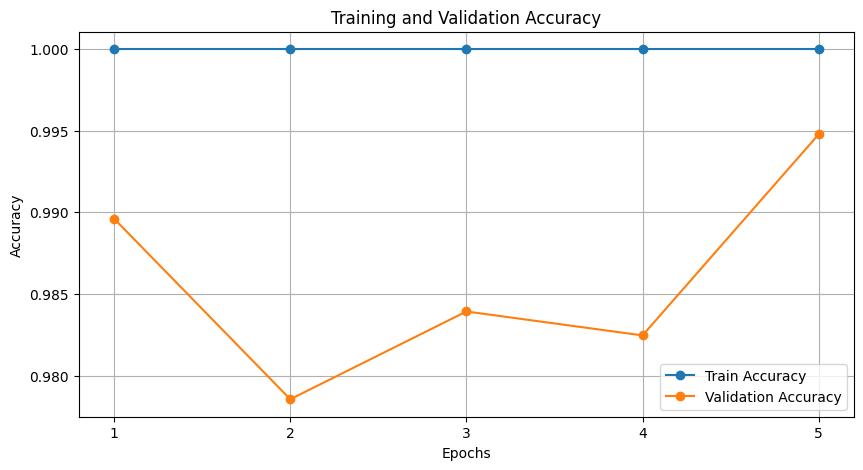

In [15]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), Train_acc, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), Val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.savefig('accuracy_plot.png')
plt.show()

## Load Best weight

In [16]:
model.load_state_dict(torch.load('models/router_best.p'))
model.eval()

Router(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

## Test Set Definition
This section defines the test set, which is the final, held-out data used to provide an unbiased evaluation of the trained model's real-world performance.

Following the same structure as the training and validation sets, it contains **test_objects_xx** lists and **test_templates_xx** dictionaries for each language. This data is never seen during the training or validation phases and serves as the ultimate benchmark for the model's generalization capabilities.

In [17]:
test_objects_en = [
    "rolling pin", "sieve", "colander", "ice cream scoop", "garlic press", "pizza cutter", "kitchen timer",
    "trowel", "rake", "sprinkler", "hammock", "bird feeder", "tent peg",
    "violin", "flute", "drumstick", "metronome", "music stand", "tuning fork",
    "laminator", "paper shredder", "projector screen", "graphics tablet", "VR headset", "joystick", "power bank",
    "caliper", "mallet", "soldering iron", "sandpaper", "zip tie", "wall anchor", "bubble wrap",
    "thermometer", "bandage", "cotton swab", "nail file", "eyedropper",
    "lint roller", "doorstop", "extension cord", "lightbulb", "fuse", "clothespin",
    "chessboard", "playing cards", "yo-yo", "frisbee", "jump rope",
    "corkscrew", "beads", "yarn", "easel", "palette", "chisel", "abacus"
]
test_objects_fa = [
    "وردنه", "الک", "آبکش", "اسکوپ بستنی", "سیر له کن", "کاتر پیتزا", "تایمر آشپزخانه",
    "بیلچه", "شن‌کش", "آب‌پاش", "ننو", "دانه خوری پرنده", "میخ چادر",
    "ویولن", "فلوت", "چوب درام", "مترونوم", "پایه نت", "دیاپازون",
    "دستگاه لمینت", "کاغذ خردکن", "پرده پروژکتور", "تبلت گرافیکی", "هدست واقعیت مجازی", "دسته بازی", "پاور بانک",
    "کولیس", "چکش چوبی", "هویه", "کاغذ سنباده", "بست کمربندی", "رولپلاک", "پلاستیک حباب‌دار",
    "دماسنج", "باند", "گوش‌پاک‌کن", "سوهان ناخن", "قطره‌چکان",
    "پرزگیر غلتکی", "نگهدارنده در", "سیم سیار", "لامپ", "فیوز", "گیره لباس",

    "صفحه شطرنج", "کارت‌های بازی", "یویو", "فریزبی", "طناب بازی",
    "چوب‌پنبه‌کش", "مهره", "کاموا", "سه‌پایه نقاشی", "پالت رنگ", "مغار", "چرتکه"
]
test_objects_de = [
    "Nudelholz", "Sieb", "Durchschlag", "Eisportionierer", "Knoblauchpresse", "Pizzaschneider", "Küchenwecker",
    "Pflanzkelle", "Rechen", "Rasensprenger", "Hängematte", "Vogelfutterhaus", "Zelthering",
    "Geige", "Flöte", "Trommelstock", "Metronom", "Notenständer", "Stimmgabel",
    "Laminiergerät", "Aktenvernichter", "Projektionsleinwand", "Grafiktablett", "VR-Headset", "Joystick", "Powerbank",
    "Messschieber", "Holzhammer", "Lötkolben", "Schleifpapier", "Kabelbinder", "Dübel", "Luftpolsterfolie",
    "Thermometer", "Verband", "Wattestäbchen", "Nagelfeile", "Pipette",
    "Fusselrolle", "Türstopper", "Verlängerungskabel", "Glühbirne", "Sicherung", "Wäscheklammer",
    "Schachbrett", "Spielkarten", "Jo-Jo", "Frisbee", "Springseil",
    "Korkenzieher", "Perlen", "Garn", "Staffelei", "Palette", "Stemmeisen", "Abakus"
]
test_objects_es = [
    "el rodillo", "el tamiz", "el colador", "la cuchara para helado", "el prensador de ajos", "el cortador de pizza", "el temporizador de cocina",
    "la pala de jardín", "el rastrillo", "el aspersor", "la hamaca", "el comedero para pájaros", "la estaca de tienda",
    "el violín", "la flauta", "la baqueta", "el metrónomo", "el atril", "el diapasón",
    "la laminadora", "la destructora de papel", "la pantalla de proyección", "la tableta gráfica", "las gafas de realidad virtual", "el joystick", "el banco de energía",
    "el calibrador", "el mazo", "el soldador", "el papel de lija", "la brida", "el anclaje de pared", "el plástico de burbujas",
    "el termómetro", "la tirita", "el hisopo de algodón", "la lima de uñas", "el cuentagotas",
    "el rodillo quitapelusas", "el tope de puerta", "el cable de extensión", "la bombilla", "el fusible", "la pinza de ropa",
    "el tablero de ajedrez", "los naipes", "el yo-yo", "el frisbee", "la comba",
    "el sacacorchos", "las cuentas", "el hilo", "el caballete", "la paleta", "el cincel", "el ábaco"
]

test_objects_ru = [
    "скалка", "сито", "дуршлаг", "ложка для мороженого", "чеснокодавилка", "нож для пиццы", "кухонный таймер",
    "совок", "грабли", "разбрызгиватель", "гамак", "кормушка для птиц", "колышек для палатки",
    "скрипка", "флейта", "барабанная палочка", "метроном", "пюпитр", "камертон",
    "ламинатор", "шредер для бумаги", "экран для проектора", "графический планшет", "VR-шлем", "джойстик", "пауэрбанк",
    "штангенциркуль", "киянка", "паяльник", "наждачная бумага", "кабельная стяжка", "дюбель", "пузырчатая плёнка",
    "термометр", "бинт", "ватная палочка", "пилочка для ногтей", "пипетка",
    "ролик для чистки одежды", "дверной упор", "удлинитель", "лампочка", "предохранитель", "прищепка",
    "шахматная доска", "игральные карты", "йо-йо", "фрисби", "скакалка",
    "штопор", "бусины", "пряжа", "мольберт", "палитра", "стамеска", "счёты"
]

test_objects_fr = [
    "rouleau à pâtisserie", "tamis", "passoire", "cuillère à glace", "presse-ail", "roulette à pizza", "minuteur de cuisine",
    "truelle", "râteau", "arroseur", "hamac", "mangeoire à oiseaux", "piquet de tente",
    "violon", "flûte", "baguette de batterie", "métronome", "pupitre", "diapason",
    "plastifieuse", "destructeur de documents", "écran de projection", "tablette graphique", "casque de réalité virtuelle", "manette de jeu", "batterie externe",
    "pied à coulisse", "maillet", "fer à souder", "papier de verre", "serre-câble", "cheville murale", "papier bulle",
    "thermomètre", "bandage", "coton-tige", "lime à ongles", "compte-gouttes",
    "rouleau anti-peluches", "cale-porte", "rallonge électrique", "ampoule", "fusible", "pince à linge",
    "échiquier", "cartes à jouer", "yo-yo", "frisbee", "corde à sauter",
    "tire-bouchon", "perles", "laine", "chevalet", "palette", "ciseau à bois", "boulier"
]


In [18]:
test_templates_en = {
    0: [
        # Complex Existence Questions
        "I'm trying to locate a {object}, could you survey the area for one?",
        "My query pertains to the existence of a {object}; what can you tell me?",
        "I have a need to know whether a {object} is present in this vicinity.",
        "Before I proceed, confirm for me: is a {object} anywhere to be found?",
        "I don't seem to spot a {object}. Can your sensors verify?",
        "Let's settle this: a {object}, is one present or not?",
        "I require confirmation on the status of a {object}. Is it in the environment?",
        "Is it true that there is no {object} available here at the moment?",
        "Report back on whether you can perceive an article matching the description of a {object}.",

        # Complex Properties Questions
        "Could you elaborate on the visual characteristics of the {object}?",
        "I require a description of the {object}'s material composition.",
        "What can you tell me regarding the dimensions and weight of the {object}?",
        "Describe the tactile qualities of the {object}, such as its texture.",
        "What specific hue or shade would you say the {object} is?",
        "You know that {object}? I was wondering about its primary function.",
        "Beyond its color, what other distinguishing features does the {object} possess?",
        "How would one go about describing the {object} to someone who has never seen it?",
        "Is the {object} something that could be considered fragile, or is it robust?",
        "Give me the full rundown on the {object}'s physical makeup.",
    ],
    1: [
        # Complex or Indirect Action Commands
        "I would be grateful if you could procure the {object} for me.",
        "The {object} is required at my current position; please facilitate its transfer.",
        "Proceed with the acquisition of the {object} and deliver it here forthwith.",
        "My next task requires the {object}. Would you be able to assist by bringing it to me?",
        "That {object} over there seems useful. I'd like to have it.",
        "Let's get that {object} from its current location to my hands.",
        "Could you see to it that the {object} is brought over here?",
        "The situation calls for the {object}. Please retrieve it.",
        "The next logical step would be to bring the {object} to me.",
        "I find myself in need of that {object}. Any chance you could grab it?",
        "If it's not too much trouble, could you please hand me that {object}?",
        "Execute a retrieval operation for the designated {object}.",
    ]
}
test_templates_fa = {
    0: [
        # سوالات پیچیده درباره وجود
        "دارم سعی می‌کنم یک {object} پیدا کنم، می‌توانی محیط را برای پیدا کردنش بررسی کنی؟",
        "درخواست من مربوط به وجود یک {object} است؛ چه اطلاعاتی در این مورد داری؟",
        "باید بدانم که آیا یک {object} در این حوالی وجود دارد یا نه.",
        "قبل از اینکه ادامه دهم، برایم تایید کن: آیا {object} جایی پیدا می‌شود؟",
        "من {object} نمی‌بینم. آیا سنسورهای تو می‌توانند تایید کنند؟",
        "بیا این موضوع را مشخص کنیم: یک {object}، اینجا هست یا نه؟",
        "به تایید وضعیت یک {object} نیاز دارم. آیا در محیط وجود دارد؟",
        "آیا درست است که در حال حاضر هیچ {object} در اینجا موجود نیست؟",
        "گزارش بده که آیا موردی مطابق با توضیحات یک {object} تشخیص می‌دهی.",

        # سوالات پیچیده درباره خصوصیات
        "می‌توانی در مورد مشخصات ظاهری {object} بیشتر توضیح دهی؟",
        "به توضیحی درباره‌ی جنس و مواد تشکیل‌دهنده {object} نیاز دارم.",
        "در مورد ابعاد و وزن {object} چه چیزی می‌توانی به من بگویی؟",
        "ویژگی‌های لمسی {object}، مانند بافت آن را توصیف کن.",
        "به نظر تو {object} دقیقاً چه رنگ یا ته‌رنگی دارد؟",
        "آن {object} را می‌بینی؟ می‌خواستم در مورد کاربرد اصلی آن بدانم.",
        "به غیر از رنگ، {object} چه ویژگی‌های متمایز دیگری دارد؟",
        "چطور می‌توان {object} را برای کسی که هرگز آن را ندیده توصیف کرد؟",
        "آیا {object} شکننده است یا مقاوم؟",
        "یک گزارش کامل از مشخصات فیزیکی {object} به من بده.",
    ],
    1: [
        # دستورات پیچیده یا غیرمستقیم
        "ممنون می‌شوم اگر {object} را برایم بیاوری.",
        "من اینجا به {object} نیاز دارم؛ لطفاً آن را به اینجا منتقل کن.",
        "برای به دست آوردن {object} اقدام کن و فوراً آن را به اینجا تحویل بده.",
        "کار بعدی من به {object} نیاز دارد. می‌توانی با آوردنش به من کمک کنی؟",
        "آن {object} که آنجاست مفید به نظر می‌رسد. می‌خواهمش.",
        "آن {object} را از جایش بردار و به من بده.",
        "می‌توانی کاری کنی که {object} به اینجا آورده شود؟",
        "شرایط ایجاب می‌کند که {object} را داشته باشیم. لطفاً آن را بیاور.",
        "قدم منطقی بعدی این است که {object} را برای من بیاوری.",
        "من به آن {object} نیاز پیدا کردم. امکانی هست که آن را برداری؟",
        "اگر زحمتی نیست، ممکن است لطفاً آن {object} را به من بدهی؟",
        "عملیات بازیابی را برای {object} مشخص‌شده اجرا کن.",
    ]
}
test_templates_de = {
    0: [
        # Complex Existence Questions (Komplexe Existenzfragen)
        "Ich versuche, ein {object} zu finden. Könnten Sie die Gegend danach absuchen?",
        "Meine Anfrage betrifft die Existenz eines {object}; was können Sie mir dazu sagen?",
        "Ich muss wissen, ob ein {object} in dieser Umgebung vorhanden ist.",
        "Bevor ich fortfahre, bestätigen Sie mir bitte: Ist hier irgendwo ein {object} zu finden?",
        "Ich kann kein {object} entdecken. Können Ihre Sensoren das überprüfen?",
        "Klären wir das: Gibt es hier ein {object} oder nicht?",
        "Ich benötige eine Bestätigung, ob ein {object} vorhanden ist. Befindet es sich in der Umgebung?",
        "Stimmt es, dass hier im Moment kein {object} verfügbar ist?",
        "Melden Sie, ob Sie einen Gegenstand wahrnehmen können, der der Beschreibung eines {object} entspricht.",

        # Complex Properties Questions (Komplexe Eigenschaftsfragen)
        "Könnten Sie die visuellen Merkmale des {object} näher erläutern?",
        "Ich benötige eine Beschreibung der materiellen Zusammensetzung des {object}.",
        "Was können Sie mir bezüglich der Abmessungen und des Gewichts des {object} sagen?",
        "Beschreiben Sie die taktilen Eigenschaften des {object}, wie zum Beispiel seine Textur.",
        "Welchen spezifischen Farbton oder welche Schattierung hat das {object} Ihrer Meinung nach?",
        "Sie sehen das {object} dort? Mich würde seine primäre Funktion interessieren.",
        "Welche anderen Unterscheidungsmerkmale besitzt das {object} außer seiner Farbe?",
        "Wie würde man das {object} jemandem beschreiben, der es noch nie gesehen hat?",
        "Ist das {object} eher zerbrechlich oder robust?",
        "Geben Sie mir eine vollständige Beschreibung der physischen Beschaffenheit des {object}.",
    ],
    1: [
        # Complex or Indirect Action Commands (Komplexe oder indirekte Handlungsbefehle)
        "Ich wäre Ihnen dankbar, wenn Sie mir das {object} beschaffen könnten.",
        "Ich benötige das {object} an meiner aktuellen Position. Bitte bringen Sie es hierher.",
        "Besorgen Sie das {object} und bringen Sie es sofort hierher.",
        "Meine nächste Aufgabe erfordert das {object}. Könnten Sie mir helfen, indem Sie es mir bringen?",
        "Dieses {object} dort drüben scheint nützlich zu sein. Ich hätte es gerne.",
        "Bringen Sie dieses {object} von seinem jetzigen Ort zu mir.",
        "Könnten Sie dafür sorgen, dass das {object} hierher gebracht wird?",
        "Die Situation erfordert das {object}. Bitte holen Sie es.",
        "Der nächste logische Schritt wäre, mir das {object} zu bringen.",
        "Ich benötige dieses {object}. Besteht die Möglichkeit, dass Sie es holen?",
        "Wenn es keine großen Umstände macht, könnten Sie mir bitte dieses {object} reichen?",
        "Führen Sie einen Beschaffungsvorgang für das vorgesehene {object} aus.",
    ]
}
test_templates_es = {
    0: [
        # Preguntas de existencia más complejas
        "Estoy tratando de localizar un {object}, ¿podría inspeccionar el área en su busca?",
        "Mi consulta se refiere a la existencia de un {object}; ¿qué me puede informar?",
        "Necesito saber si hay un {object} presente en estas inmediaciones.",
        "Antes de proceder, confírmeme: ¿se puede encontrar un {object} en alguna parte?",
        "No parezco divisar un {object}. ¿Pueden sus sensores verificarlo?",
        "Aclaremos esto: un {object}, ¿está presente o no?",
        "Requiero confirmación sobre el estado de un {object}. ¿Está en el entorno?",
        "¿Es cierto que no hay ningún {object} disponible aquí en este momento?",
        "Infórmeme sobre si puede percibir un artículo que coincida con la descripción de un {object}.",

        # Preguntas de propiedades más complejas
        "¿Podría dar más detalles sobre las características visuales del {object}?",
        "Requiero una descripción de la composición material del {object}.",
        "¿Qué me puede decir sobre las dimensiones y el peso del {object}?",
        "Describa las cualidades táctiles del {object}, como por ejemplo su textura.",
        "¿Qué tonalidad o matiz específico diría que tiene el {object}?",
        "Sabe, ese {object}... me preguntaba cuál es su función principal.",
        "Más allá de su color, ¿qué otras características distintivas posee el {object}?",
        "¿Cómo se le podría describir el {object} a alguien que nunca lo ha visto?",
        "¿Se podría considerar el {object} como algo frágil o es más bien robusto?",
        "Deme un informe completo sobre la constitución física del {object}.",
    ],
    1: [
        # Órdenes de acción más complejas o indirectas
        "Le agradecería si pudiera procurarme el {object}.",
        "Se requiere el {object} en mi posición actual; por favor, facilite su traslado.",
        "Proceda con la adquisición del {object} y entréguelo aquí de inmediato.",
        "Mi siguiente tarea requiere el {object}. ¿Sería posible que me ayudara trayéndolo?",
        "Ese {object} de allí parece útil. Me gustaría tenerlo.",
        "Hagamos que ese {object} llegue desde su ubicación actual hasta mis manos.",
        "¿Podría encargarse de que el {object} sea traído hasta aquí?",
        "La situación exige el uso del {object}. Por favor, recupérelo.",
        "El siguiente paso lógico sería traer el {object} hasta mí.",
        "Me encuentro en la necesidad de ese {object}. ¿Habría alguna posibilidad de que lo cogiera?",
        "Si no es mucha molestia, ¿podría por favor pasarme ese {object}?",
        "Ejecute una operación de recuperación para el {object} designado.",
    ]
}

test_templates_ru = {
    0: [
        # Complex Existence Questions (Сложные вопросы о существовании)
        "Я пытаюсь найти {object}, не могли бы вы осмотреть территорию на его наличие?",
        "Мой вопрос касается наличия {object}; что вы можете об этом сказать?",
        "Мне необходимо знать, присутствует ли {object} поблизости.",
        "Прежде чем я продолжу, подтвердите: {object} здесь где-нибудь есть?",
        "Я не вижу {object}. Ваши датчики могут это проверить?",
        "Давайте проясним: {object} здесь есть или нет?",
        "Мне требуется подтверждение наличия {object}. Он есть в окружении?",
        "Верно ли, что здесь сейчас нет {object}?",
        "Сообщите, видите ли вы объект, соответствующий описанию {object}.",

        # Complex Properties Questions (Сложные вопросы о свойствах)
        "Не могли бы вы подробнее описать внешний вид {object}?",
        "Мне требуется описание материала, из которого состоит {object}.",
        "Что вы можете сказать о размерах и весе {object}?",
        "Опишите {object} на ощупь, например, его текстуру.",
        "Какого конкретно цвета или оттенка {object}?",
        "Видите тот {object}? Меня интересует его основное предназначение.",
        "Кроме цвета, какие ещё отличительные черты есть у {object}?",
        "Как бы вы описали {object} человеку, который его никогда не видел?",
        "{object} хрупкий или прочный?",
        "Дайте мне полное описание физических свойств {object}.",
    ],
    1: [
        # Complex or Indirect Action Commands (Сложные или косвенные команды к действию)
        "Я был бы благодарен, если бы вы принесли мне {object}.",
        "{object} нужен мне здесь; пожалуйста, доставьте его.",
        "Возьмите {object} и немедленно доставьте его сюда.",
        "Для следующего задания мне нужен {object}. Не могли бы вы помочь, принеся его мне?",
        "Тот {object} кажется полезным. Я бы хотел его получить.",
        "Давайте переместим тот {object} с его места ко мне в руки.",
        "Не могли бы вы позаботиться о том, чтобы {object} принесли сюда?",
        "Ситуация требует {object}. Пожалуйста, принесите его.",
        "Следующий логичный шаг — принести {object} мне.",
        "Мне понадобился тот {object}. Не могли бы вы его принести?",
        "Если вас не затруднит, не могли бы вы передать мне тот {object}?",
        "Выполните операцию по получению указанного {object}.",
    ]
}

test_templates_fr = {
    0: [
        # Complex Existence Questions
        "Je tente de localiser un {object}, pourriez-vous examiner la zone pour en trouver un ?",
        "Ma requête concerne l'existence d'un {object} ; que pouvez-vous me dire ?",
        "J'ai besoin de savoir si un {object} est présent dans les environs.",
        "Avant de continuer, confirmez-moi : peut-on trouver un {object} quelque part ?",
        "Il ne me semble pas voir d'{object}. Vos capteurs peuvent-ils le confirmer ?",
        "Tranchons la question : y a-t-il un {object} ou pas ?",
        "J'ai besoin d'une confirmation concernant un {object}. Se trouve-t-il dans l'environnement ?",
        "Est-il vrai qu'il n'y a pas d'{object} disponible ici en ce moment ?",
        "Dites-moi si vous percevez un objet correspondant à la description d'un {object}.",

        # Complex Properties Questions
        "Pourriez-vous détailler les caractéristiques visuelles de l'{object} ?",
        "J'ai besoin d'une description des matériaux qui composent l'{object}.",
        "Que pouvez-vous me dire concernant les dimensions et le poids de l'{object} ?",
        "Décrivez les qualités tactiles de l'{object}, comme sa texture.",
        "De quelle teinte ou nuance spécifique diriez-vous que l'{object} est ?",
        "Vous voyez cet {object} ? Je me demandais quelle est sa fonction principale.",
        "Au-delà de sa couleur, quelles autres caractéristiques distinctives l'{object} possède-t-il ?",
        "Comment décrirait-on l'{object} à quelqu'un qui ne l'a jamais vu ?",
        "L'{object} peut-il être considéré comme fragile, ou est-il robuste ?",
        "Donnez-moi un compte-rendu complet de la constitution physique de l'{object}.",
    ],
    1: [
        # Complex or Indirect Action Commands
        "Je vous serais reconnaissant si vous pouviez me procurer l'{object}.",
        "J'ai besoin de l'{object} à ma position actuelle ; veuillez faciliter son déplacement.",
        "Récupérez l'{object} et apportez-le-moi immédiatement.",
        "Ma prochaine tâche nécessite l'{object}. Pourriez-vous m'aider en me l'apportant ?",
        "Cet {object} là-bas semble utile. J'aimerais l'avoir.",
        "Faisons en sorte que cet {object} passe de son emplacement actuel à mes mains.",
        "Pourriez-vous veiller à ce que l'{object} soit apporté ici ?",
        "La situation exige l'{object}. Veuillez le récupérer.",
        "La prochaine étape logique serait de m'apporter l'{object}.",
        "J'ai besoin de cet {object}. Pourriez-vous l'attraper ?",
        "Si ce n'est pas trop demander, pourriez-vous me passer cet {object} ?",
        "Exécutez une opération de récupération pour l'{object} désigné.",
    ]
}


In [19]:
# Generate Test dataset
Test_dataset={
    'en': generate_dataset(test_templates_en, test_objects_en),
    'fa': generate_dataset(test_templates_fa, test_objects_fa),
    'de': generate_dataset(test_templates_de, test_objects_de),
    'es': generate_dataset(test_templates_es, test_objects_es),
    'ru': generate_dataset(test_templates_ru, test_objects_ru),
    'fr': generate_dataset(test_templates_fr, test_objects_fr)
}

# Save Test datasets
for lang, dataset in Test_dataset.items():
    test_df = pd.DataFrame(dataset)
    test_df.to_csv(f"test_dataset_{lang}.csv", index=False, encoding='utf-8-sig')
    print(f"Test dataset for {lang} generated with {len(dataset)} samples and saved as 'test_dataset_{lang}.csv'.")

Test dataset for en generated with 1736 samples and saved as 'test_dataset_en.csv'.
Test dataset for fa generated with 1736 samples and saved as 'test_dataset_fa.csv'.
Test dataset for de generated with 1736 samples and saved as 'test_dataset_de.csv'.
Test dataset for es generated with 1736 samples and saved as 'test_dataset_es.csv'.
Test dataset for ru generated with 1736 samples and saved as 'test_dataset_ru.csv'.
Test dataset for fr generated with 1736 samples and saved as 'test_dataset_fr.csv'.


## Final Model Evaluation on Test Sets
This code block performs the final evaluation of the trained model on the unseen test data. The process is repeated for each language's specific test set (e.g., English, Farsi, etc.).

For each language, it loads the corresponding test CSV, prepares the data using the DataLoader, and then calls the model_accuracy function to calculate the final performance. The resulting accuracy score is printed, providing a clear benchmark of how well the model generalizes to new, real-world data for each language.

English Test

In [20]:
test_df = pd.read_csv("test_dataset_en.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test English Dataset Accuracy: {100 * test_epoch_acc:.2f}%')

Test English Dataset Accuracy: 92.86%


Farsi Test

In [21]:
test_df = pd.read_csv("test_dataset_fa.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test Farsi Dataset Accuracy: {100 * test_epoch_acc:.2f}%')

Test Farsi Dataset Accuracy: 87.50%


Germany Test

In [22]:
test_df = pd.read_csv("test_dataset_de.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test German Dataset Accuracy: {100 * test_epoch_acc:.2f}%')


Test German Dataset Accuracy: 78.23%


Spanish Test

In [23]:
test_df = pd.read_csv("test_dataset_es.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test Spanish Dataset Accuracy: {100 * test_epoch_acc:.2f}%')


Test Spanish Dataset Accuracy: 88.94%


Russian Test

In [24]:
test_df = pd.read_csv("test_dataset_ru.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test Russian Dataset Accuracy: {100 * test_epoch_acc:.2f}%')


Test Russian Dataset Accuracy: 87.15%


French Test

In [25]:
test_df = pd.read_csv("test_dataset_fr.csv", encoding='utf-8-sig')
test_texts = test_df['question'].tolist()
test_labels = [int(label) for label in test_df['class'].tolist()]
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_epoch_acc = model_accuracy(model, test_loader)
print(f'Test French Dataset Accuracy: {100 * test_epoch_acc:.2f}%')

Test French Dataset Accuracy: 91.24%
